In [2]:
import os
import sys
HOME_DIR = '/Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering'
os.chdir(HOME_DIR)

DATASETS_DIR = f'{HOME_DIR}/datasets'
DATA_DIR = f'{DATASETS_DIR}/08'
BONING_DATASET_FILE = f'{DATA_DIR}/ampc2/Boning.csv'
SLICING_DATASET_FILE = f'{DATA_DIR}/ampc2/Slicing.csv'

print(f'HOME_DIR: {HOME_DIR}')
print(f'DATASETS_DIR: {DATASETS_DIR}')
print(f'DATA_DIR: {DATA_DIR}')
print(f'BONING_DATASET_FILE: {BONING_DATASET_FILE}')
print(f'SLICING_DATASET_FILE: {SLICING_DATASET_FILE}')

HOME_DIR: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering
DATASETS_DIR: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets
DATA_DIR: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/08
BONING_DATASET_FILE: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/08/ampc2/Boning.csv
SLICING_DATASET_FILE: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/08/ampc2/Slicing.csv


In [3]:
!pip install --upgrade pip --quiet
!pip install -r requirements.txt --quiet

In [4]:
import math
import json
import pandas as pd
import numpy as np

from scipy.integrate import simpson as simps
from scipy.signal import find_peaks

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# NOTE:
# Column Set 1: L5 (x, y, z)
# Column Set 2: T12 (x, y, z)

# Dataset Inspection

BoningCSV

In [6]:
# Load Boning dataset
boning_df = pd.read_csv(BONING_DATASET_FILE)

In [7]:
# Boning dataset shape
boning_df.shape

(54180, 67)

In [8]:
# Boning dataset columns
boning_df.columns

Index(['Frame', 'L5 x', 'L5 y', 'L5 z', 'L3 x', 'L3 y', 'L3 z', 'T12 x',
       'T12 y', 'T12 z', 'T8 x', 'T8 y', 'T8 z', 'Neck x', 'Neck y', 'Neck z',
       'Head x', 'Head y', 'Head z', 'Right Shoulder x', 'Right Shoulder y',
       'Right Shoulder z', 'Right Upper Arm x', 'Right Upper Arm y',
       'Right Upper Arm z', 'Right Forearm x', 'Right Forearm y',
       'Right Forearm z', 'Right Hand x', 'Right Hand y', 'Right Hand z',
       'Left Shoulder x', 'Left Shoulder y', 'Left Shoulder z',
       'Left Upper Arm x', 'Left Upper Arm y', 'Left Upper Arm z',
       'Left Forearm x', 'Left Forearm y', 'Left Forearm z', 'Left Hand x',
       'Left Hand y', 'Left Hand z', 'Right Upper Leg x', 'Right Upper Leg y',
       'Right Upper Leg z', 'Right Lower Leg x', 'Right Lower Leg y',
       'Right Lower Leg z', 'Right Foot x', 'Right Foot y', 'Right Foot z',
       'Right Toe x', 'Right Toe y', 'Right Toe z', 'Left Upper Leg x',
       'Left Upper Leg y', 'Left Upper Leg z', 'Left Lower

In [9]:
# First 5 rows
boning_df.head(5)

Frame      L5 x      L5 y      L5 z      L3 x      L3 y      L3 z  \
0      0  0.052654  0.039386 -0.077002  0.076056  0.056891 -0.111225   
1      1 -0.053525  0.117279  0.150245 -0.078560  0.171968  0.217296   
2      2  0.073929 -0.022381  0.032701  0.105559 -0.029586  0.047209   
3      3 -0.037295 -0.009975  0.015846 -0.032722  0.003632  0.038552   
4      4  0.091745 -0.014404  0.054168  0.132364 -0.018714  0.078221   

      T12 x     T12 y     T12 z  ...  Left Upper Leg z  Left Lower Leg x  \
0  0.099458  0.074396 -0.145448  ...          0.011806          0.121231   
1 -0.103594  0.226658  0.284348  ...          0.231347          0.094984   
2  0.137189 -0.036791  0.061717  ...          0.062618          0.028965   
3 -0.028150  0.017239  0.061258  ...          0.006895         -0.063305   
4  0.172983 -0.023023  0.102274  ...          0.017431          0.077462   

   Left Lower Leg y  Left Lower Leg z  Left Foot x  Left Foot y  Left Foot z  \
0         -0.079631          0.020690     0.124997    -0.169401     0.003467   
1          0.134901          0.073241     0.099210     0.315884     0.099760   
2          0.138562          0.047474     0.037484    -0.038600     0.031238   
3          0.215892          0.038873     0.077475     0.000989     0.111197   
4          0.142185          0.044010     0.145175    -0.009129     0.074555   

   Left Toe x  Left Toe y  Left Toe z  
0    0.124997   -0.169401    0.003467  
1    0.091222    0.314948    0.099742  
2    0.029455   -0.039869    0.031214  
3    0.047133   -0.008699    0.026959  
4    0.138419   -0.012442    0.074571  

[5 rows x 67 columns]

In [10]:
# Last 5 rows
boning_df.tail(5)

Frame      L5 x      L5 y      L5 z      L3 x      L3 y      L3 z  \
54175  54175 -0.517198 -0.015782 -0.122907 -0.756456 -0.016568 -0.176368   
54176  54176  0.129974 -0.162556 -0.308774  0.087942 -0.128618 -0.364683   
54177  54177  0.379037 -0.104331  0.090104  0.539296 -0.145616  0.129932   
54178  54178  0.022015 -0.110805  0.088934  0.024395 -0.160585  0.128186   
54179  54179  0.132618 -0.101097  0.067043  0.208750 -0.127851  0.105071   

          T12 x     T12 y     T12 z  ...  Left Upper Leg z  Left Lower Leg x  \
54175 -0.995715 -0.017354 -0.229829  ...         -0.072791          0.391113   
54176  0.045909 -0.094680 -0.420593  ...         -0.070595          0.860149   
54177  0.699554 -0.186900  0.169760  ...         -0.206584          0.146210   
54178  0.026775 -0.210365  0.167437  ...          0.270664         -0.519476   
54179  0.284883 -0.154605  0.143100  ...          0.144120         -0.720352   

       Left Lower Leg y  Left Lower Leg z  Left Foot x  Left Foot y  \
54175         -0.742073         -0.083342    -0.795359    -0.336933   
54176         -0.467361         -0.161265     0.097514    -0.059214   
54177         -0.339723         -0.125023    -0.004569    -0.071033   
54178          0.390552          0.202116    -0.751282    -0.187910   
54179          1.383447          0.109772    -0.619973     0.008978   

       Left Foot z  Left Toe x  Left Toe y  Left Toe z  
54175    -0.507823   -0.797533   -0.307028   -0.507163  
54176    -0.460668    0.165085   -0.033804   -0.487299  
54177    -0.322283   -0.026291   -0.037563   -0.322689  
54178     0.311200   -0.776450   -0.155341    0.310363  
54179     0.417641   -0.685214   -0.033804    0.198063  

[5 rows x 67 columns]

In [11]:
boning_df.describe()

Frame          L5 x          L5 y          L5 z          L3 x  \
count  54180.000000  54180.000000  54180.000000  54180.000000  54180.000000   
mean   27089.500000     -0.004635     -0.000110      0.003835     -0.005254   
std    15640.563129      0.670811      0.566650      0.434615      0.960774   
min        0.000000     -9.529681    -11.050340     -5.469383    -13.745627   
25%    13544.750000     -0.227320     -0.177936     -0.144189     -0.322647   
50%    27089.500000     -0.003885      0.006770      0.001380     -0.004432   
75%    40634.250000      0.223235      0.200544      0.151893      0.317472   
max    54179.000000     14.950358      9.819392      8.911717     21.592190   

               L3 y          L3 z         T12 x         T12 y         T12 z  \
count  54180.000000  54180.000000  54180.000000  54180.000000  54180.000000   
mean       0.000970      0.005874     -0.005874      0.002050      0.007912   
std        0.795684      0.615253      1.253266      1.028811      0.798510   
min      -15.926846     -7.818795    -17.961573    -20.803352    -10.225488   
25%       -0.248738     -0.204484     -0.418456     -0.319794     -0.265078   
50%        0.010191      0.002568     -0.003918      0.014029      0.004139   
75%        0.282270      0.214741      0.413233      0.364757      0.279794   
max       14.172133     10.501353     28.234023     18.524873     13.728549   

       ...  Left Upper Leg z  Left Lower Leg x  Left Lower Leg y  \
count  ...      54180.000000      54180.000000      54180.000000   
mean   ...         -0.019230          0.003445         -0.008191   
std    ...          0.725964          1.323737          1.497188   
min    ...        -12.208943        -22.596462        -29.606227   
25%    ...         -0.206531         -0.380573         -0.494484   
50%    ...         -0.006699         -0.005292          0.002966   
75%    ...          0.181934          0.355966          0.487547   
max    ...         10.755519         20.546986         19.930001   

       Left Lower Leg z   Left Foot x   Left Foot y   Left Foot z  \
count      54180.000000  54180.000000  54180.000000  54180.000000   
mean          -0.007893     -0.004595      0.004648     -0.005782   
std            0.690409      1.721424      1.193410      1.084819   
min          -21.340287    -49.250083    -28.082640    -24.859754   
25%           -0.186468     -0.348061     -0.316125     -0.217815   
50%           -0.003856     -0.014317      0.005533      0.008176   
75%            0.168172      0.287229      0.332724      0.243013   
max           13.468850     42.949162     30.498145     26.118296   

         Left Toe x    Left Toe y    Left Toe z  
count  54180.000000  54180.000000  54180.000000  
mean      -0.001711      0.004516      0.002089  
std        1.684979      1.189246      1.074874  
min      -36.543737    -26.660149    -24.721795  
25%       -0.346676     -0.316855     -0.205948  
50%       -0.015485      0.004969      0.014001  
75%        0.286848      0.332680      0.245344  
max       41.990168     29.772758     25.546454  

[8 rows x 67 columns]

In [12]:
boning_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54180 entries, 0 to 54179
Data columns (total 67 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Frame              54180 non-null  int64  
 1   L5 x               54180 non-null  float64
 2   L5 y               54180 non-null  float64
 3   L5 z               54180 non-null  float64
 4   L3 x               54180 non-null  float64
 5   L3 y               54180 non-null  float64
 6   L3 z               54180 non-null  float64
 7   T12 x              54180 non-null  float64
 8   T12 y              54180 non-null  float64
 9   T12 z              54180 non-null  float64
 10  T8 x               54180 non-null  float64
 11  T8 y               54180 non-null  float64
 12  T8 z               54180 non-null  float64
 13  Neck x             54180 non-null  float64
 14  Neck y             54180 non-null  float64
 15  Neck z             54180 non-null  float64
 16  Head x             541

In [13]:
# Check for missing values
missing_values = boning_df.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values[missing_values > 0])

Missing Values in Each Column:
Series([], dtype: int64)


SlicingCSV

In [14]:
# Load Slicing dataset
slicing_df = pd.read_csv(SLICING_DATASET_FILE)

In [15]:
# Slicing dataset shape
slicing_df.shape

(17880, 67)

In [16]:
# Slicing dataset columns
slicing_df.columns

Index(['Frame', 'L5 x', 'L5 y', 'L5 z', 'L3 x', 'L3 y', 'L3 z', 'T12 x',
       'T12 y', 'T12 z', 'T8 x', 'T8 y', 'T8 z', 'Neck x', 'Neck y', 'Neck z',
       'Head x', 'Head y', 'Head z', 'Right Shoulder x', 'Right Shoulder y',
       'Right Shoulder z', 'Right Upper Arm x', 'Right Upper Arm y',
       'Right Upper Arm z', 'Right Forearm x', 'Right Forearm y',
       'Right Forearm z', 'Right Hand x', 'Right Hand y', 'Right Hand z',
       'Left Shoulder x', 'Left Shoulder y', 'Left Shoulder z',
       'Left Upper Arm x', 'Left Upper Arm y', 'Left Upper Arm z',
       'Left Forearm x', 'Left Forearm y', 'Left Forearm z', 'Left Hand x',
       'Left Hand y', 'Left Hand z', 'Right Upper Leg x', 'Right Upper Leg y',
       'Right Upper Leg z', 'Right Lower Leg x', 'Right Lower Leg y',
       'Right Lower Leg z', 'Right Foot x', 'Right Foot y', 'Right Foot z',
       'Right Toe x', 'Right Toe y', 'Right Toe z', 'Left Upper Leg x',
       'Left Upper Leg y', 'Left Upper Leg z', 'Left Lower

In [17]:
# First 5 rows
slicing_df.head(5)

Frame      L5 x      L5 y      L5 z      L3 x      L3 y      L3 z  \
0      0 -0.012539 -0.023092 -0.037696 -0.018112 -0.033355 -0.054450   
1      1 -0.014146  0.057422  0.017591 -0.019864  0.082837  0.025461   
2      2 -0.073246 -0.014965 -0.014101 -0.105308 -0.021510 -0.020315   
3      3 -0.054076  0.019098  0.006340 -0.091487  0.011623  0.013548   
4      4 -0.088772 -0.193634 -0.011749 -0.127064 -0.279901 -0.017003   

      T12 x     T12 y     T12 z  ...  Left Upper Leg z  Left Lower Leg x  \
0 -0.023685 -0.043617 -0.071204  ...         -0.004247          0.015117   
1 -0.025582  0.108252  0.033332  ...         -0.009161          0.047860   
2 -0.137370 -0.028054 -0.026528  ...          0.005529         -0.096096   
3 -0.128898  0.004149  0.020757  ...         -0.014663         -0.075465   
4 -0.165355 -0.366168 -0.022256  ...         -0.017543          0.009852   

   Left Lower Leg y  Left Lower Leg z  Left Foot x  Left Foot y  Left Foot z  \
0         -0.109421         -0.007150     0.047547    -0.069688    -0.023800   
1          0.037084         -0.016778     0.059598     0.036626    -0.005471   
2          0.022938          0.062969    -0.032496    -0.040150     0.042961   
3         -0.056221          0.088429    -0.013296    -0.016638     0.105897   
4         -0.207643          0.031294     0.070038    -0.096551     0.004033   

   Left Toe x  Left Toe y  Left Toe z  
0    0.047547   -0.069688   -0.023800  
1    0.057358    0.035208   -0.005450  
2   -0.034332   -0.041492    0.042953  
3   -0.021412   -0.028961    0.077145  
4    0.068555   -0.098178    0.004050  

[5 rows x 67 columns]

In [18]:
# Last 5 rows
slicing_df.tail(5)

Frame      L5 x      L5 y      L5 z      L3 x      L3 y      L3 z  \
17875  17875 -0.299632 -0.055806  0.064378 -0.434314 -0.087950  0.093503   
17876  17876 -0.256818 -0.067065  0.088435 -0.360567 -0.130262  0.112538   
17877  17877 -0.135368 -0.239857  0.035852 -0.195806 -0.355807  0.053062   
17878  17878 -0.083036 -0.293007 -0.017898 -0.120276 -0.432056 -0.024654   
17879  17879 -0.126037 -0.156934 -0.015643 -0.171985 -0.280832 -0.046323   

          T12 x     T12 y     T12 z  ...  Left Upper Leg z  Left Lower Leg x  \
17875 -0.568995 -0.120094  0.122627  ...         -0.250397         -2.051169   
17876 -0.464315 -0.193459  0.136641  ...         -0.122861         -2.354977   
17877 -0.256244 -0.471757  0.070272  ...          0.015247         -2.852749   
17878 -0.157517 -0.571106 -0.031410  ...         -0.125277         -2.966915   
17879 -0.217932 -0.404730 -0.077003  ...          0.189956         -2.526932   

       Left Lower Leg y  Left Lower Leg z  Left Foot x  Left Foot y  \
17875         -3.845730         -0.278676     4.596440    -2.999468   
17876         -3.357652         -0.292587     4.164559    -3.926063   
17877         -3.375176         -0.385981     3.282034    -4.473908   
17878         -3.296036         -0.582545     2.481092    -4.773027   
17879         -2.886883         -0.800261     1.490555    -5.016424   

       Left Foot z  Left Toe x  Left Toe y  Left Toe z  
17875     0.662151    4.778641   -2.542876    0.671927  
17876     0.864322    4.191308   -3.940403    0.804323  
17877     0.917019    3.494279   -4.091495    0.972747  
17878     0.753708    2.699702   -4.434226    0.824499  
17879     0.861750    1.583905   -5.074351    0.762694  

[5 rows x 67 columns]

In [19]:
# Slicing dataset description
slicing_df.describe()

Frame          L5 x          L5 y          L5 z          L3 x  \
count  17880.000000  17880.000000  17880.000000  17880.000000  17880.000000   
mean    8939.500000     -0.006705     -0.001351      0.001939     -0.009135   
std     5161.655742      0.355046      0.511220      0.367829      0.505387   
min        0.000000     -4.334696     -4.201705     -4.161487     -6.251185   
25%     4469.750000     -0.193574     -0.221773     -0.163092     -0.276062   
50%     8939.500000     -0.010425      0.007169     -0.001701     -0.014919   
75%    13409.250000      0.176314      0.233068      0.164536      0.252685   
max    17879.000000      3.511343      6.062532      3.497136      5.088239   

               L3 y          L3 z         T12 x         T12 y         T12 z  \
count  17880.000000  17880.000000  17880.000000  17880.000000  17880.000000   
mean      -0.000063      0.003088     -0.011566      0.001225      0.004238   
std        0.731958      0.530224      0.657288      0.954120      0.692918   
min       -6.073993     -6.011000     -8.167674     -7.946280     -7.860512   
25%       -0.314960     -0.234861     -0.359114     -0.407428     -0.306643   
50%        0.010316     -0.002465     -0.019526      0.014712     -0.002741   
75%        0.333246      0.237616      0.329502      0.434702      0.309903   
max        8.721543      5.051719      6.665136     11.380555      6.606302   

       ...  Left Upper Leg z  Left Lower Leg x  Left Lower Leg y  \
count  ...      17880.000000      17880.000000      17880.000000   
mean   ...         -0.007176          0.005632         -0.003387   
std    ...          0.446662          1.320231          0.878274   
min    ...         -9.745262        -24.162910        -13.699668   
25%    ...         -0.140864         -0.407356         -0.326056   
50%    ...         -0.003334         -0.009949          0.009744   
75%    ...          0.132515          0.379674          0.318482   
max    ...          7.389414         16.464169         18.014811   

       Left Lower Leg z   Left Foot x   Left Foot y   Left Foot z  \
count      17880.000000  17880.000000  17880.000000  17880.000000   
mean          -0.057102     -0.000595      0.002532     -0.008118   
std            0.826135      1.345048      1.032964      0.896490   
min           -9.843720    -18.051601    -25.960464    -22.347965   
25%           -0.125448     -0.296061     -0.293306     -0.156649   
50%           -0.004554     -0.010291     -0.013837      0.007091   
75%            0.115925      0.260862      0.268519      0.173175   
max           11.609954     21.436803     41.805967     15.837935   

         Left Toe x    Left Toe y    Left Toe z  
count  17880.000000  17880.000000  17880.000000  
mean       0.000146      0.000813     -0.000244  
std        1.339497      1.047566      0.893955  
min      -18.222505    -25.809129    -21.961980  
25%       -0.299148     -0.294161     -0.148987  
50%       -0.010313     -0.016037      0.015622  
75%        0.261276      0.268239      0.178849  
max       21.078066     42.093178     15.997508  

[8 rows x 67 columns]

In [20]:
# Slicing dataset information
slicing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 67 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Frame              17880 non-null  int64  
 1   L5 x               17880 non-null  float64
 2   L5 y               17880 non-null  float64
 3   L5 z               17880 non-null  float64
 4   L3 x               17880 non-null  float64
 5   L3 y               17880 non-null  float64
 6   L3 z               17880 non-null  float64
 7   T12 x              17880 non-null  float64
 8   T12 y              17880 non-null  float64
 9   T12 z              17880 non-null  float64
 10  T8 x               17880 non-null  float64
 11  T8 y               17880 non-null  float64
 12  T8 z               17880 non-null  float64
 13  Neck x             17880 non-null  float64
 14  Neck y             17880 non-null  float64
 15  Neck z             17880 non-null  float64
 16  Head x             178

In [21]:
# Slicing dataset missing values
slicing_df.isna().sum()

Frame          0
L5 x           0
L5 y           0
L5 z           0
L3 x           0
              ..
Left Foot y    0
Left Foot z    0
Left Toe x     0
Left Toe y     0
Left Toe z     0
Length: 67, dtype: int64

In [22]:
# Check for missing values
missing_values = slicing_df.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values[missing_values > 0])

Missing Values in Each Column:
Series([], dtype: int64)


# Dataset Collection

In [23]:
# Defined columns to extract
columns_to_extract = ['Frame', 'L5 x', 'L5 y', 'L5 z', 'T12 x', 'T12 y', 'T12 z']

In [24]:
# Extract columns
boning_data = boning_df[columns_to_extract].copy()
slicing_data = slicing_df[columns_to_extract].copy()

# Print DataFrame Inspection
print(f'----------------------------------------')
print(f'Boning Data Shape: {boning_data.shape}')
print(f'Slicing Data Shape: {slicing_data.shape}')
print(f'----------------------------------------')
print(f'Boning Data Columns: {boning_data.columns}')
print(f'Slicing Data Columns: {slicing_data.columns}')
print(f'----------------------------------------')
print(f'Boning Data Info: {boning_data.info()}')
print(f'Slicing Data Info: {slicing_data.info()}')
print(f'----------------------------------------')
print(f'Boning Data Missing Values: {boning_data.isna().sum()}')
print(f'Slicing Data Missing Values: {slicing_data.isna().sum()}')
print(f'----------------------------------------')
print(f'Boning Data First 5 Rows: {boning_data.head()}')
print(f'Slicing Data First 5 Rows: {slicing_data.head()}')
print(f'----------------------------------------')

----------------------------------------
Boning Data Shape: (54180, 7)
Slicing Data Shape: (17880, 7)
----------------------------------------
Boning Data Columns: Index(['Frame', 'L5 x', 'L5 y', 'L5 z', 'T12 x', 'T12 y', 'T12 z'], dtype='object')
Slicing Data Columns: Index(['Frame', 'L5 x', 'L5 y', 'L5 z', 'T12 x', 'T12 y', 'T12 z'], dtype='object')
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54180 entries, 0 to 54179
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Frame   54180 non-null  int64  
 1   L5 x    54180 non-null  float64
 2   L5 y    54180 non-null  float64
 3   L5 z    54180 non-null  float64
 4   T12 x   54180 non-null  float64
 5   T12 y   54180 non-null  float64
 6   T12 z   54180 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 2.9 MB
Boning Data Info: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (t

In [25]:
# Add class labels
boning_data['class'] = 0  # Boning
slicing_data['class'] = 1  # Slicing

In [26]:
# Merge Boning and Slicing datasets
combined_data = pd.concat([boning_data, slicing_data])
combined_data.to_csv(f'{DATA_DIR}/combined_data.csv', index=False)

# Print DataFrame Inspection
print(f'----------------------------------------')
print(f'Combined DF Shape: {combined_data.shape}')
print(f'----------------------------------------')
print(f'Combined DF Columns: {combined_data.columns}')
print(f'----------------------------------------')
print(f'Combined DF Info: {combined_data.info()}')
print(f'----------------------------------------')
print(f'Combined DF Missing Values: {combined_data.isna().sum()}')
print(f'----------------------------------------')
print(f'Combined DF First 5 Rows: {combined_data.head()}')
print(f'----------------------------------------')

----------------------------------------
Combined DF Shape: (72060, 8)
----------------------------------------
Combined DF Columns: Index(['Frame', 'L5 x', 'L5 y', 'L5 z', 'T12 x', 'T12 y', 'T12 z', 'class'], dtype='object')
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 72060 entries, 0 to 17879
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Frame   72060 non-null  int64  
 1   L5 x    72060 non-null  float64
 2   L5 y    72060 non-null  float64
 3   L5 z    72060 non-null  float64
 4   T12 x   72060 non-null  float64
 5   T12 y   72060 non-null  float64
 6   T12 z   72060 non-null  float64
 7   class   72060 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 4.9 MB
Combined DF Info: None
----------------------------------------
Combined DF Missing Values: Frame    0
L5 x     0
L5 y     0
L5 z     0
T12 x    0
T12 y    0
T12 z    0
class    0
dtype: int64
-----------------

Class distribution before grouping:
class
0    54180
1    17880
Name: count, dtype: int64


/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/2610718458.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=combined_data, palette="viridis")


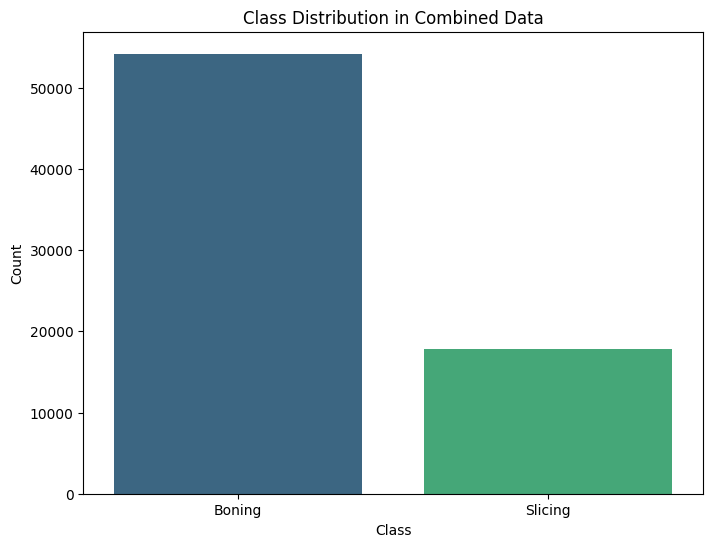

In [54]:
# Check the distribution of the classes
print("Class distribution before grouping:")
class_distribution = combined_data['class'].value_counts()
print(class_distribution)

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=combined_data, palette="viridis")
plt.title('Class Distribution in Combined Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Boning', 'Slicing'])
plt.show()


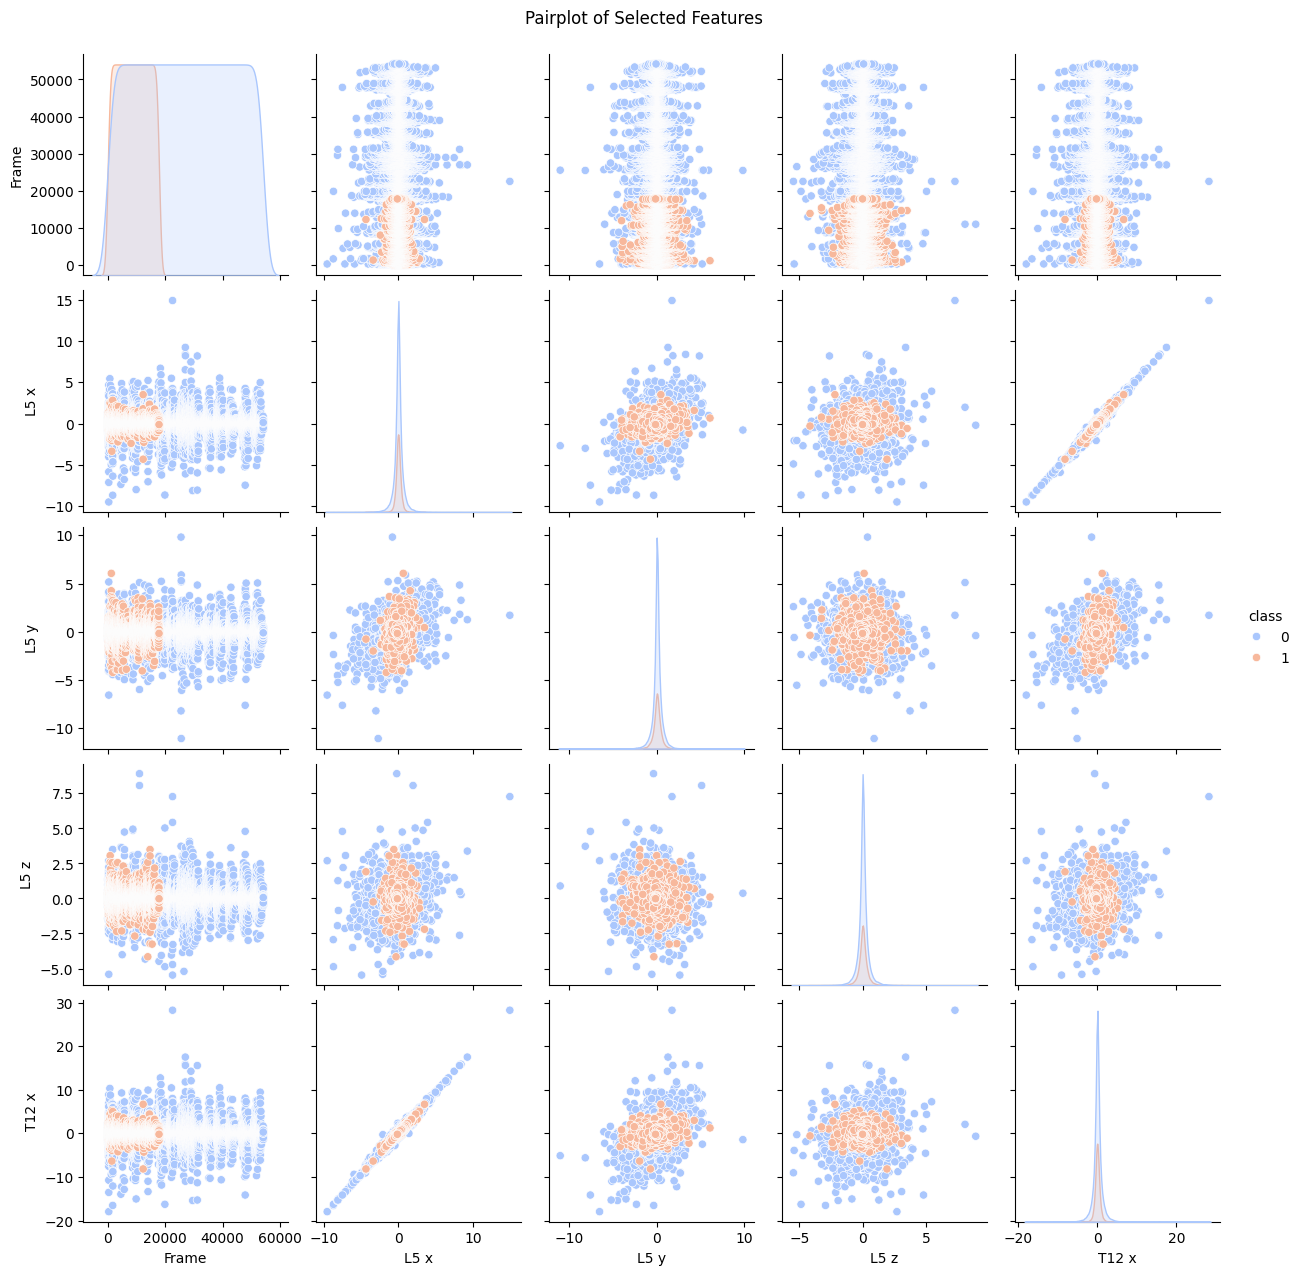

In [28]:
# Select a subset of columns for visualization
columns_for_pairplot = combined_data.columns[:5].tolist() + ['class']  # Adjust as needed

# Plot pairplot
sns.pairplot(combined_data[columns_for_pairplot], hue='class', palette="coolwarm", diag_kind="kde")
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()


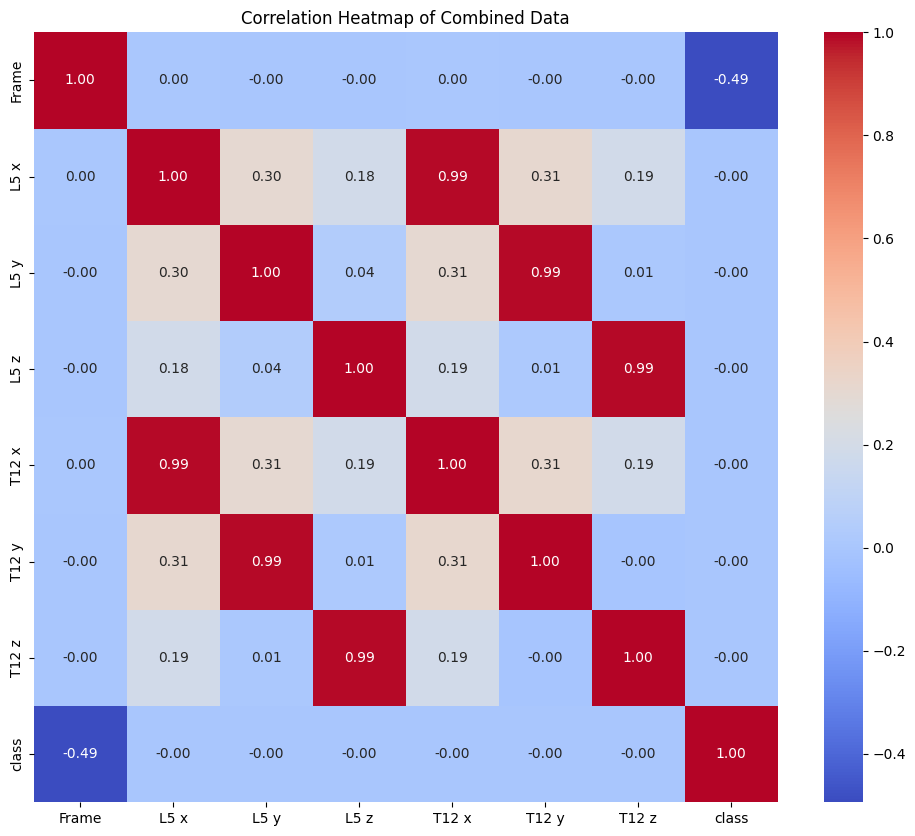

In [29]:
# Compute correlation matrix
correlation_matrix = combined_data.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Heatmap of Combined Data')
plt.show()


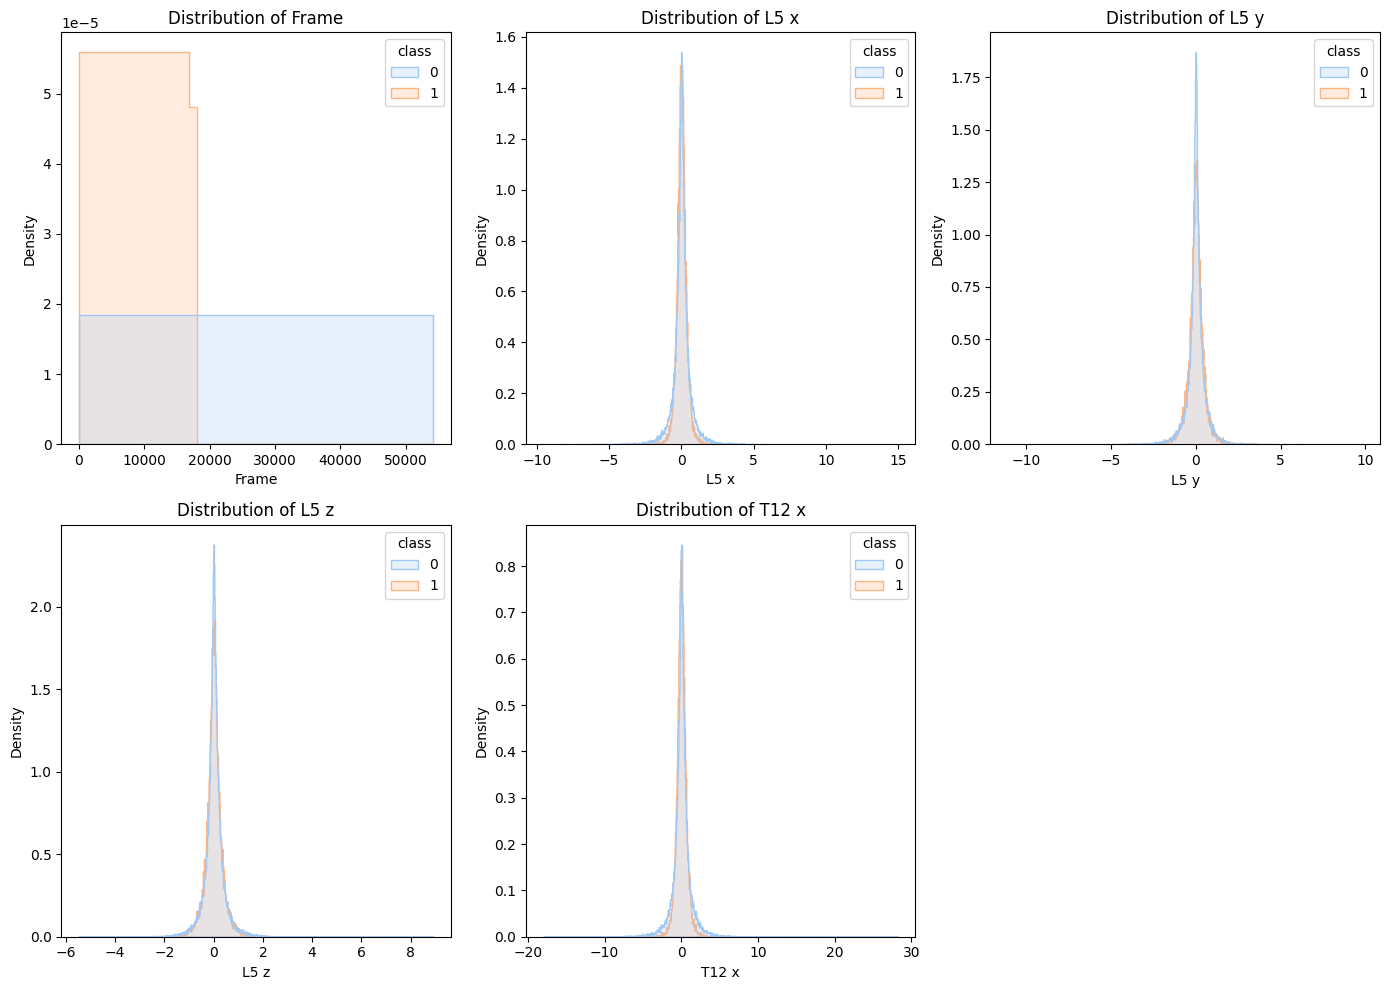

In [30]:
# Select features for distribution plots
features_to_plot = combined_data.columns[:5] 

# Plot distribution of selected features
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=combined_data, x=feature, hue='class', element="step", stat="density", common_norm=False, palette="pastel")
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()


/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/1957610696.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=feature, data=combined_data, palette="Set3")
/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/1957610696.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=feature, data=combined_data, palette="Set3")
/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/1957610696.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=feature, data=combined_data, palet

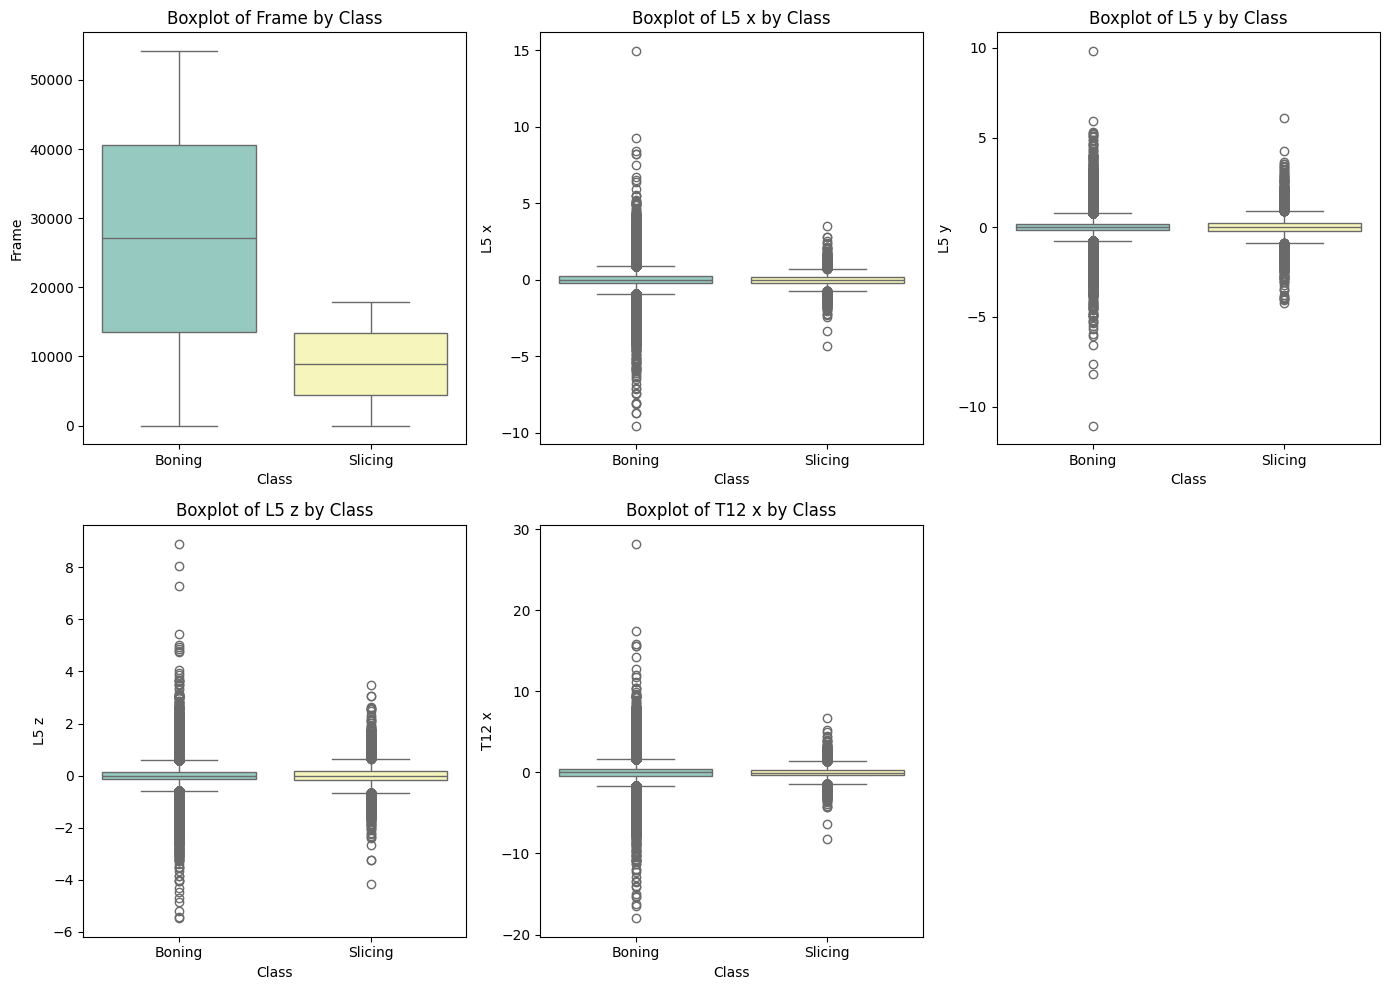

In [31]:
# Plot boxplots of selected features
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='class', y=feature, data=combined_data, palette="Set3")
    plt.title(f'Boxplot of {feature} by Class')
    plt.xlabel('Class')
    plt.ylabel(feature)
    plt.xticks(ticks=[0, 1], labels=['Boning', 'Slicing'])
plt.tight_layout()
plt.show()


/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/1118119670.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y=feature, data=combined_data, palette="muted")
/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/1118119670.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y=feature, data=combined_data, palette="muted")
/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/1118119670.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y=feature, data=combined_

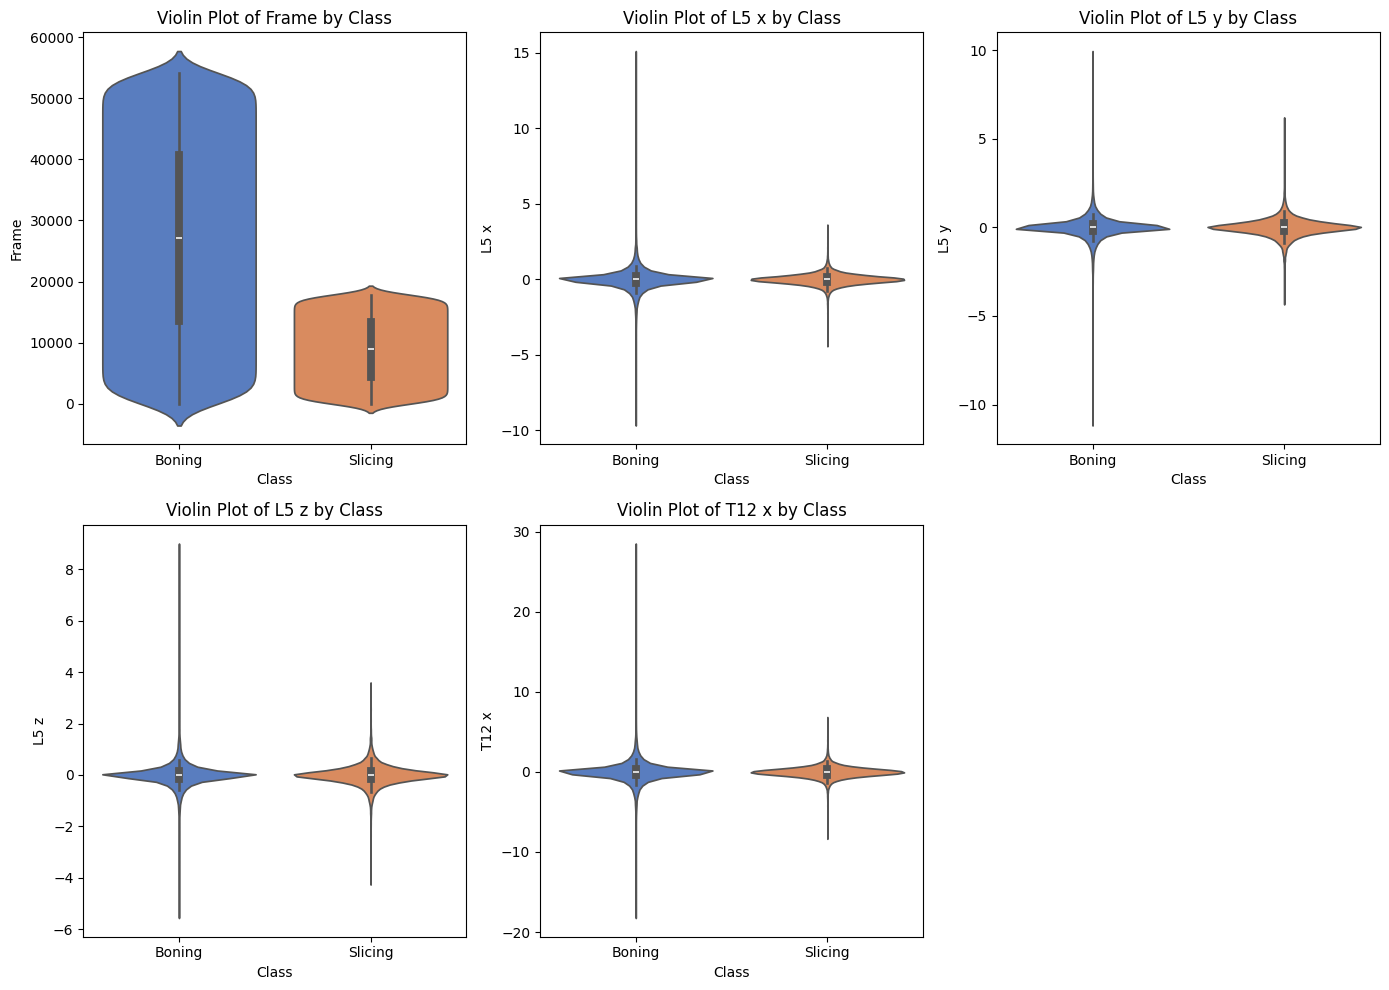

In [32]:
# Plot violin plots of selected features
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x='class', y=feature, data=combined_data, palette="muted")
    plt.title(f'Violin Plot of {feature} by Class')
    plt.xlabel('Class')
    plt.ylabel(feature)
    plt.xticks(ticks=[0, 1], labels=['Boning', 'Slicing'])
plt.tight_layout()
plt.show()


# Dataset Composite Columns

In [33]:
# TODO
# 1) Root mean square value of x and y 
# 2) Root mean square value of y and z 
# 3) Root mean square value of z and x 
# 4) Root mean square value of x, y and z 
# 5) Roll (180 * atan2(accelY, sqrt(accelX*accelX + accelZ*accelZ))/PI) 
# 6) Pitch (180 * atan2(accelX, sqrt(accelY*accelY + accelZ*accelZ))/PI) 

In [34]:
# Load the original combined data
combined_data = pd.read_csv(f'{DATA_DIR}/combined_data.csv')

# Compute composite columns
combined_data['RMS_xy'] = np.sqrt(combined_data['L5 x']**2 + combined_data['L5 y']**2)
combined_data['RMS_yz'] = np.sqrt(combined_data['L5 y']**2 + combined_data['L5 z']**2)
combined_data['RMS_zx'] = np.sqrt(combined_data['L5 z']**2 + combined_data['L5 x']**2)
combined_data['RMS_xyz'] = np.sqrt(combined_data['L5 x']**2 + combined_data['L5 y']**2 + combined_data['L5 z']**2)

combined_data['Roll'] = 180 * np.arctan2(combined_data['L5 y'], np.sqrt(combined_data['L5 x']**2 + combined_data['L5 z']**2)) / np.pi
combined_data['Pitch'] = 180 * np.arctan2(combined_data['L5 x'], np.sqrt(combined_data['L5 y']**2 + combined_data['L5 z']**2)) / np.pi

combined_data.head()

Frame      L5 x      L5 y      L5 z     T12 x     T12 y     T12 z  class  \
0      0  0.052654  0.039386 -0.077002  0.099458  0.074396 -0.145448      0   
1      1 -0.053525  0.117279  0.150245 -0.103594  0.226658  0.284348      0   
2      2  0.073929 -0.022381  0.032701  0.137189 -0.036791  0.061717      0   
3      3 -0.037295 -0.009975  0.015846 -0.028150  0.017239  0.061258      0   
4      4  0.091745 -0.014404  0.054168  0.172983 -0.023023  0.102274      0   

     RMS_xy    RMS_yz    RMS_zx   RMS_xyz       Roll      Pitch  
0  0.065755  0.086490  0.093283  0.101257  22.890444  31.332626  
1  0.128916  0.190599  0.159495  0.197972  36.327537 -15.686203  
2  0.077243  0.039627  0.080839  0.083880 -15.474967  61.808452  
3  0.038606  0.018725  0.040521  0.041731 -13.829694 -63.340086  
4  0.092869  0.056051  0.106543  0.107512  -7.699627  58.577410

Class distribution before grouping:
class
0    54180
1    17880
Name: count, dtype: int64


/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/2578175257.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")


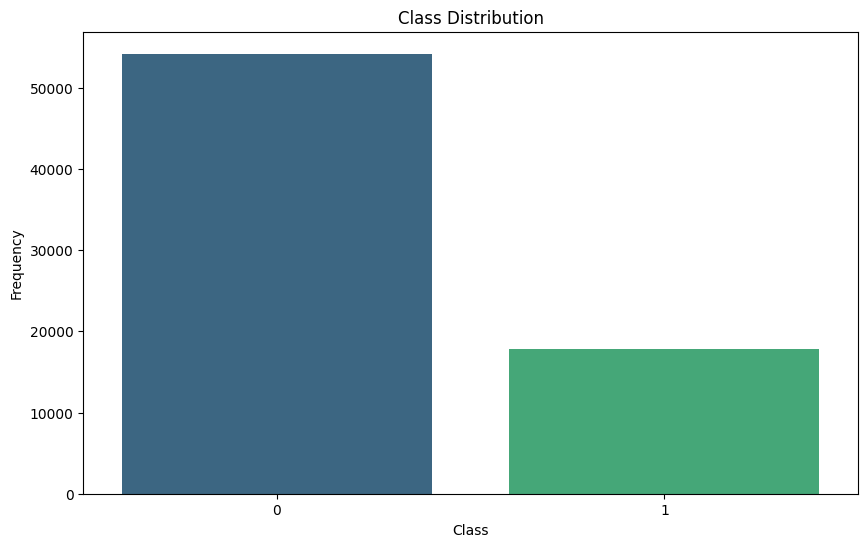

Frame          L5 x          L5 y          L5 z         T12 x  \
count  72060.000000  72060.000000  72060.000000  72060.000000  72060.000000   
mean   22586.002914     -0.005149     -0.000418      0.003365     -0.007286   
std    15874.387643      0.607955      0.553411      0.419036      1.134964   
min        0.000000     -9.529681    -11.050340     -5.469383    -17.961573   
25%     9007.000000     -0.217291     -0.188501     -0.149155     -0.398634   
50%    18149.500000     -0.005312      0.006834      0.000695     -0.008232   
75%    36164.250000      0.209263      0.209207      0.155183      0.387225   
max    54179.000000     14.950358      9.819392      8.911717     28.234023   

              T12 y         T12 z         class        RMS_xy        RMS_yz  \
count  72060.000000  72060.000000  72060.000000  72060.000000  72060.000000   
mean       0.001845      0.007000      0.248127      0.553438      0.473358   
std        1.010787      0.773652      0.431929      0.607949      0.507736   
min      -20.803352    -10.225488      0.000000      0.001025      0.000726   
25%       -0.341621     -0.275600      0.000000      0.188933      0.157427   
50%        0.014108      0.002845      0.000000      0.371840      0.317192   
75%        0.383178      0.287440      0.000000      0.698762      0.610816   
max       18.524873     13.728549      1.000000     15.049108     11.086600   

             RMS_zx       RMS_xyz          Roll         Pitch  
count  72060.000000  72060.000000  72060.000000  72060.000000  
mean       0.492378      0.645979      1.098557     -0.884870  
std        0.550272      0.658944     40.719744     43.049484  
min        0.000684      0.005408    -89.618663    -89.649849  
25%        0.169073      0.243899    -30.632372    -36.188767  
50%        0.328637      0.452644      1.398260     -1.112382  
75%        0.610770      0.818997     33.118810     34.263733  
max       16.626080     16.714934     89.438380     89.901601

In [35]:
# Check the distribution of the classes
print("Class distribution before grouping:")
class_distribution = combined_data['class'].value_counts()
print(class_distribution)

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Summary statistics of the dataset
combined_data.describe()

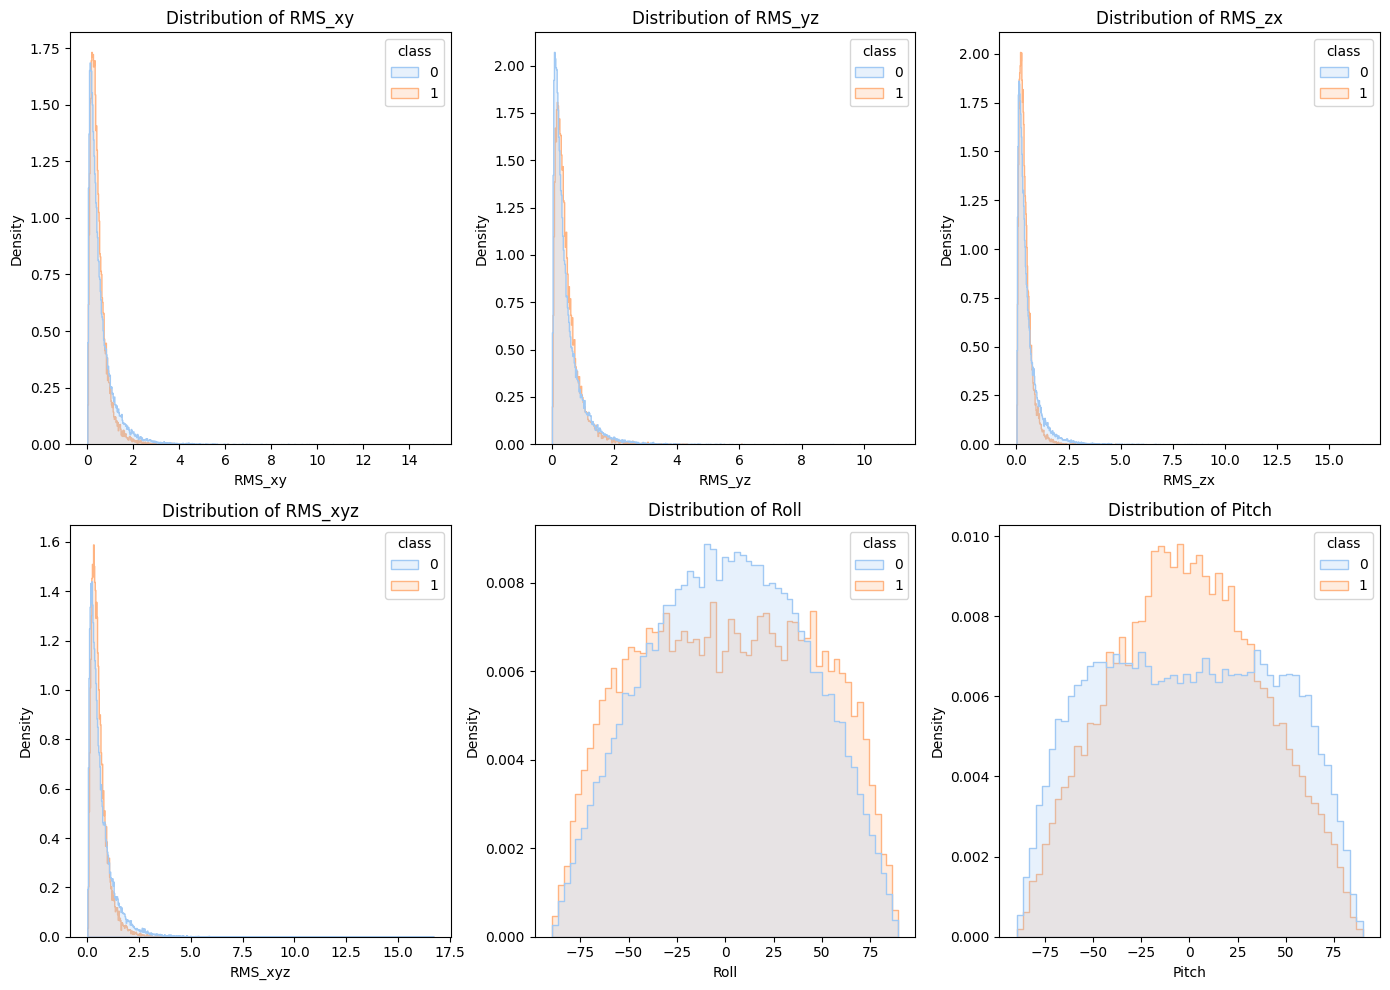

In [36]:
# Plot distribution of individual features
composite_columns = ['RMS_xy', 'RMS_yz', 'RMS_zx', 'RMS_xyz', 'Roll', 'Pitch']
plt.figure(figsize=(14, 10))
for i, column in enumerate(composite_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=combined_data, x=column, hue='class', element="step", stat="density", common_norm=False, palette="pastel")
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()


/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/2325592211.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=column, data=combined_data, palette="Set3")
/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/2325592211.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=column, data=combined_data, palette="Set3")
/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/2325592211.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=column, data=combined_data, palette=

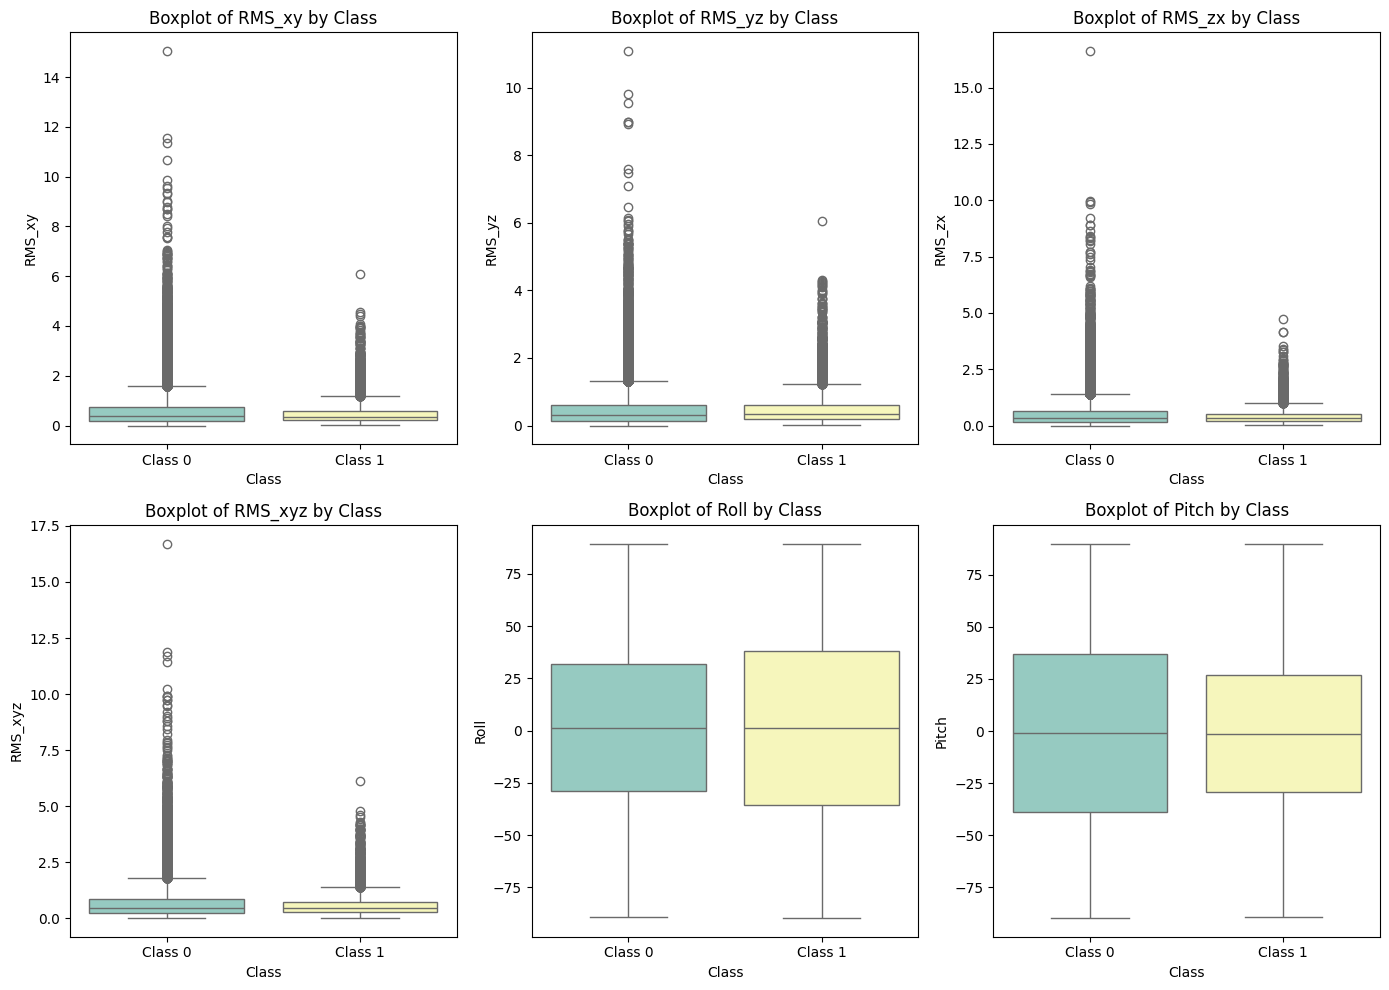

In [37]:
# Plot boxplots of composite columns
plt.figure(figsize=(14, 10))
for i, column in enumerate(composite_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='class', y=column, data=combined_data, palette="Set3")
    plt.title(f'Boxplot of {column} by Class')
    plt.xlabel('Class')
    plt.ylabel(column)
    plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])  # Adjust labels if necessary
plt.tight_layout()
plt.show()


/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/1025011833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y=column, data=combined_data, palette="muted")
/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/1025011833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y=column, data=combined_data, palette="muted")
/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/1025011833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y=column, data=combined_dat

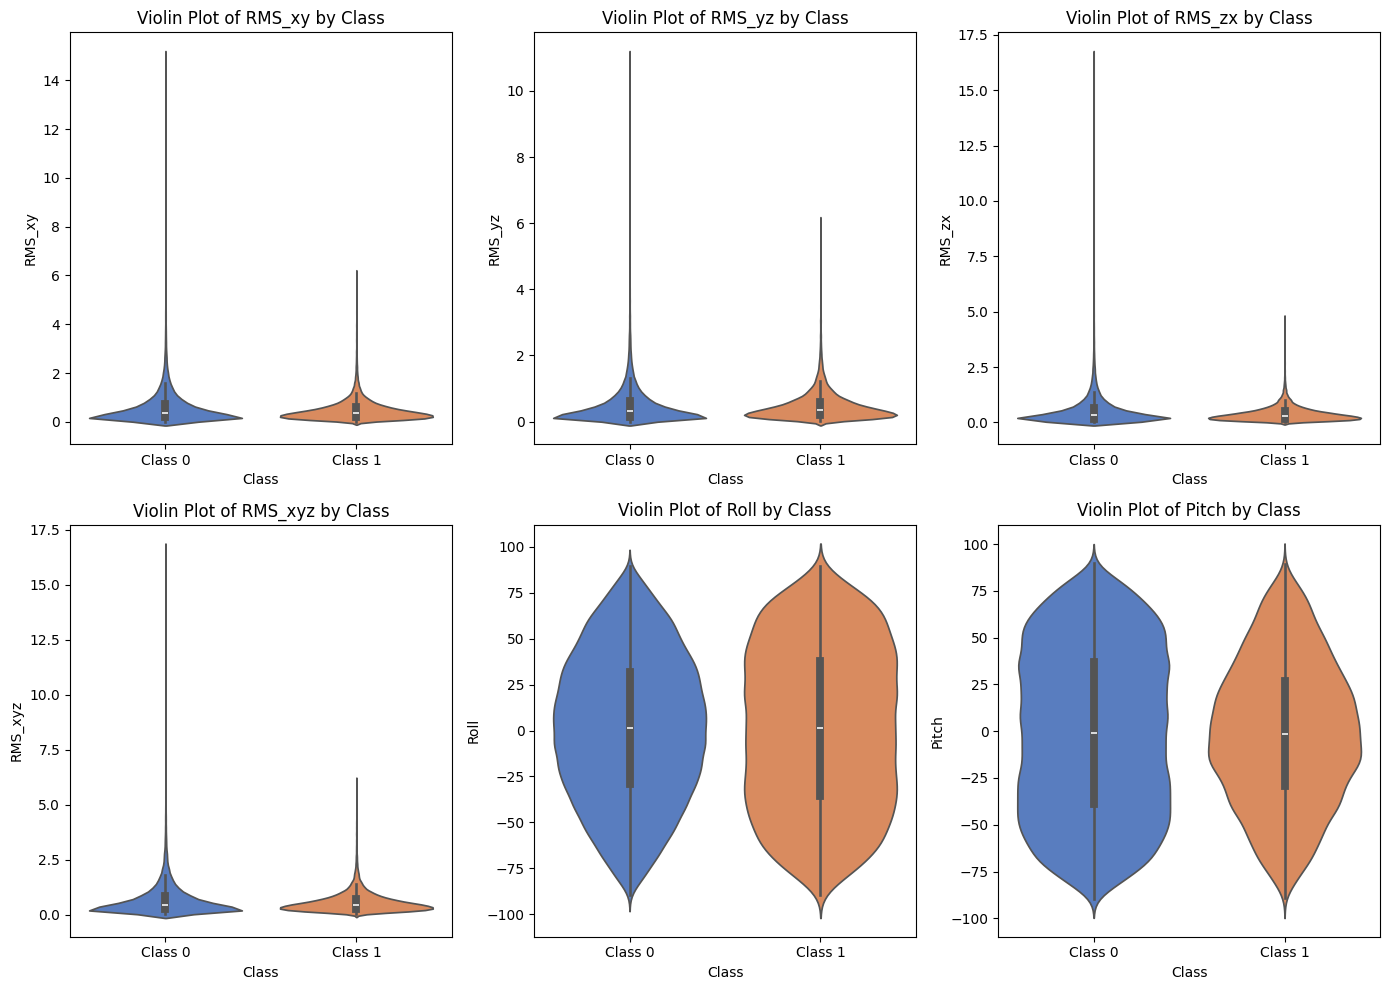

In [38]:
# Plot violin plots of composite columns
plt.figure(figsize=(14, 10))
for i, column in enumerate(composite_columns, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x='class', y=column, data=combined_data, palette="muted")
    plt.title(f'Violin Plot of {column} by Class')
    plt.xlabel('Class')
    plt.ylabel(column)
    plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])  # Adjust labels if necessary
plt.tight_layout()
plt.show()


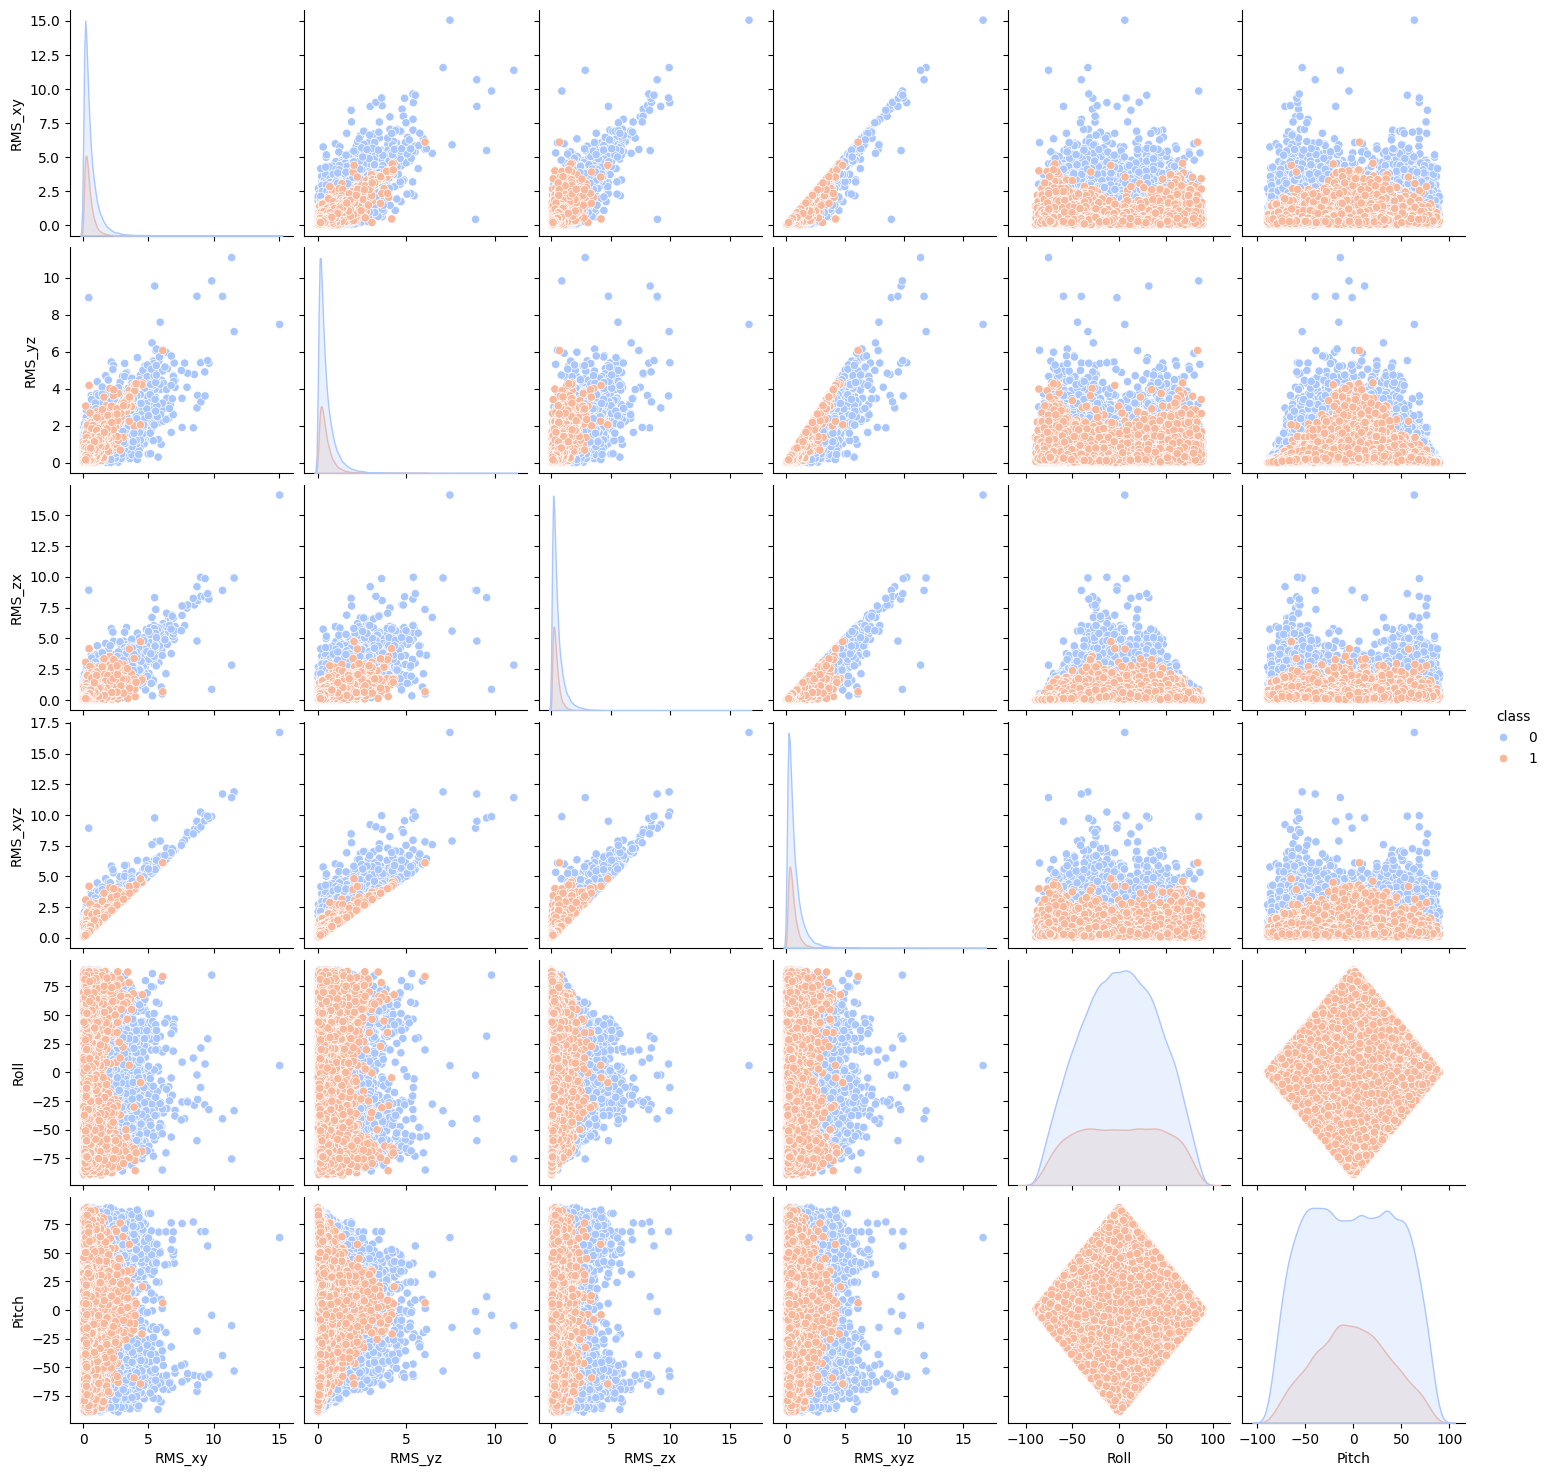

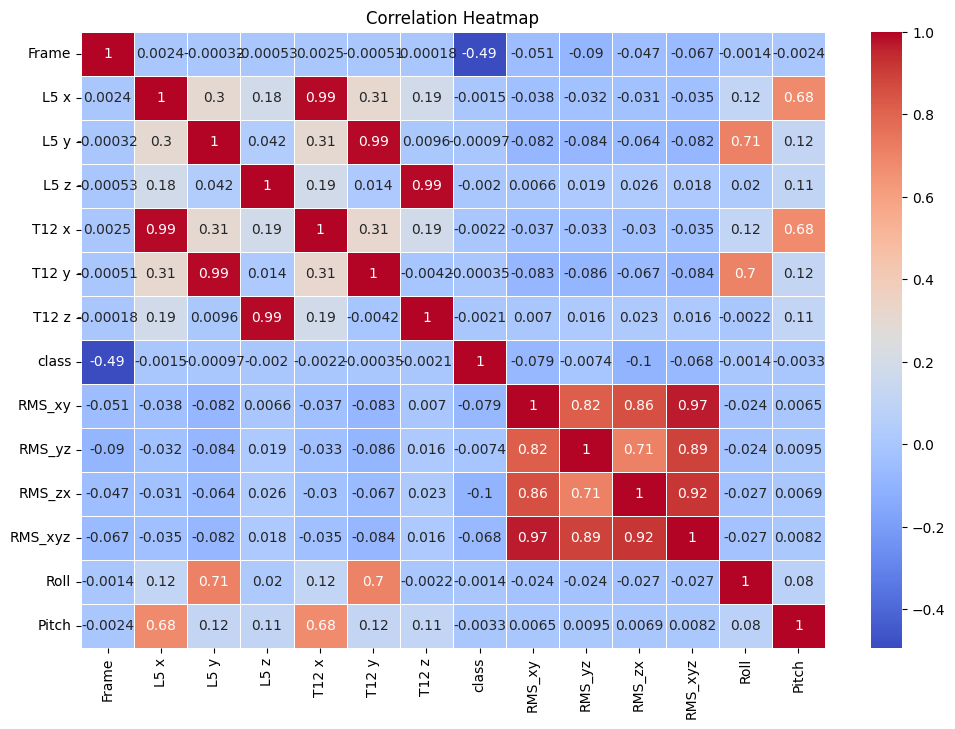

In [39]:
# Pairplot of the computed columns and the original 'class' column
sns.pairplot(combined_data, vars=['RMS_xy', 'RMS_yz', 'RMS_zx', 'RMS_xyz', 'Roll', 'Pitch'], hue='class', palette="coolwarm")
plt.show()

# Correlation heatmap of the numerical columns
plt.figure(figsize=(12, 8))
correlation_matrix = combined_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Data Pre Processing


In [40]:
# Function to compute features for each column
def compute_features(df):
    features = {}
    for col in df.columns[1:-1]:  # Skip 'frame' and 'class'
        features[col + '_mean'] = df[col].mean()
        features[col + '_std'] = df[col].std()
        features[col + '_min'] = df[col].min()
        features[col + '_max'] = df[col].max()
        features[col + '_auc'] = simps(df[col])
        features[col + '_peaks'] = len(find_peaks(df[col])[0])
    return pd.Series(features)

# Group by each minute (assuming 60 frames per minute)
grouped_data = combined_data.groupby(['class', combined_data['Frame'] // 60]).apply(compute_features)

# Reset index
grouped_data = grouped_data.reset_index()

# Reassign class labels correctly
grouped_data['class'] = grouped_data['class'].astype(int)

# Save the reprocessed data
grouped_data.to_csv(f'{DATA_DIR}/processed_grouped_data.csv', index=False)

# Print DataFrame Inspection
print(f'Processed Data Shape: {grouped_data.shape}')
print(f'Processed Data Columns: {grouped_data.columns}')
print(f'Processed Data Info: {grouped_data.info()}')
print(f'Processed Data First 5 Rows: {grouped_data.head()}')


Processed Data Shape: (1201, 74)
Processed Data Columns: Index(['class', 'Frame', 'L5 x_mean', 'L5 x_std', 'L5 x_min', 'L5 x_max',
       'L5 x_auc', 'L5 x_peaks', 'L5 y_mean', 'L5 y_std', 'L5 y_min',
       'L5 y_max', 'L5 y_auc', 'L5 y_peaks', 'L5 z_mean', 'L5 z_std',
       'L5 z_min', 'L5 z_max', 'L5 z_auc', 'L5 z_peaks', 'T12 x_mean',
       'T12 x_std', 'T12 x_min', 'T12 x_max', 'T12 x_auc', 'T12 x_peaks',
       'T12 y_mean', 'T12 y_std', 'T12 y_min', 'T12 y_max', 'T12 y_auc',
       'T12 y_peaks', 'T12 z_mean', 'T12 z_std', 'T12 z_min', 'T12 z_max',
       'T12 z_auc', 'T12 z_peaks', 'class_mean', 'class_std', 'class_min',
       'class_max', 'class_auc', 'class_peaks', 'RMS_xy_mean', 'RMS_xy_std',
       'RMS_xy_min', 'RMS_xy_max', 'RMS_xy_auc', 'RMS_xy_peaks', 'RMS_yz_mean',
       'RMS_yz_std', 'RMS_yz_min', 'RMS_yz_max', 'RMS_yz_auc', 'RMS_yz_peaks',
       'RMS_zx_mean', 'RMS_zx_std', 'RMS_zx_min', 'RMS_zx_max', 'RMS_zx_auc',
       'RMS_zx_peaks', 'RMS_xyz_mean', 'RMS_xyz

/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/3597276173.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_data = combined_data.groupby(['class', combined_data['Frame'] // 60]).apply(compute_features)


Processed grouped data class distribution:
class
0    903
1    298
Name: count, dtype: int64


/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/3181905187.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_class_distribution.index, y=grouped_class_distribution.values, palette="plasma")


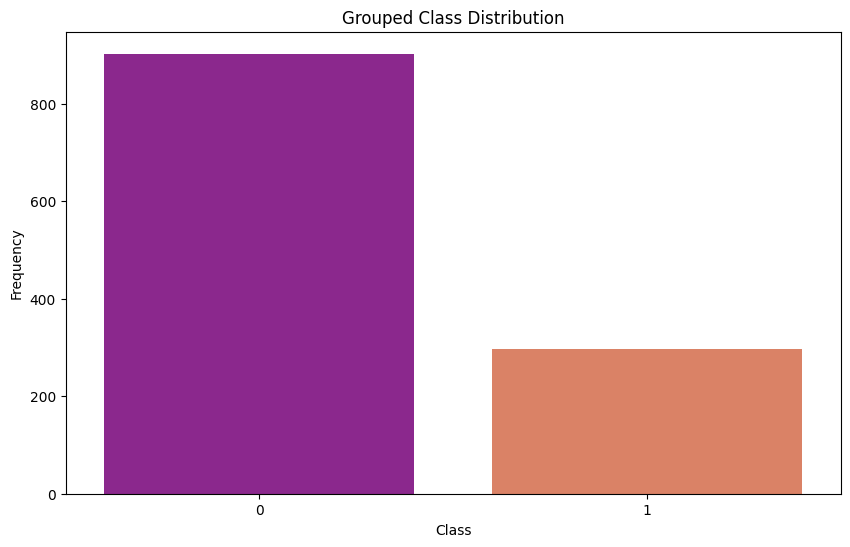

In [41]:
# Check the new class distribution after grouping
print("Processed grouped data class distribution:")
grouped_class_distribution = grouped_data['class'].value_counts()
print(grouped_class_distribution)

# Plot grouped class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=grouped_class_distribution.index, y=grouped_class_distribution.values, palette="plasma")
plt.title('Grouped Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

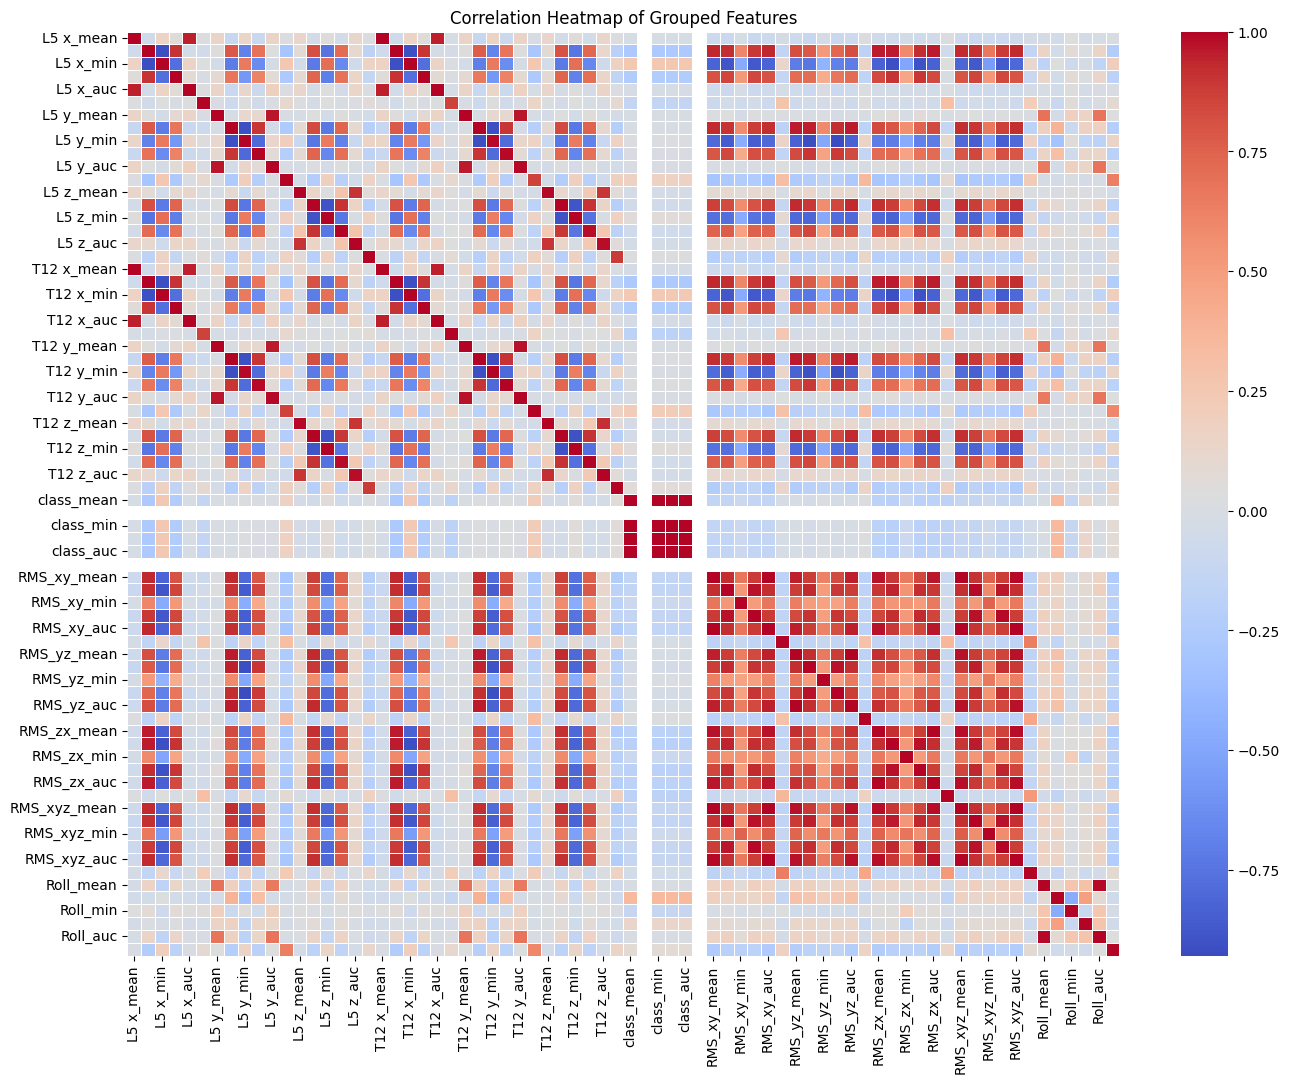

In [42]:
# Compute correlation matrix for the grouped data
correlation_matrix_grouped = grouped_data.iloc[:, 2:].corr()  # Skip 'class' and 'Frame'

# Plot correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix_grouped, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap of Grouped Features')
plt.show()


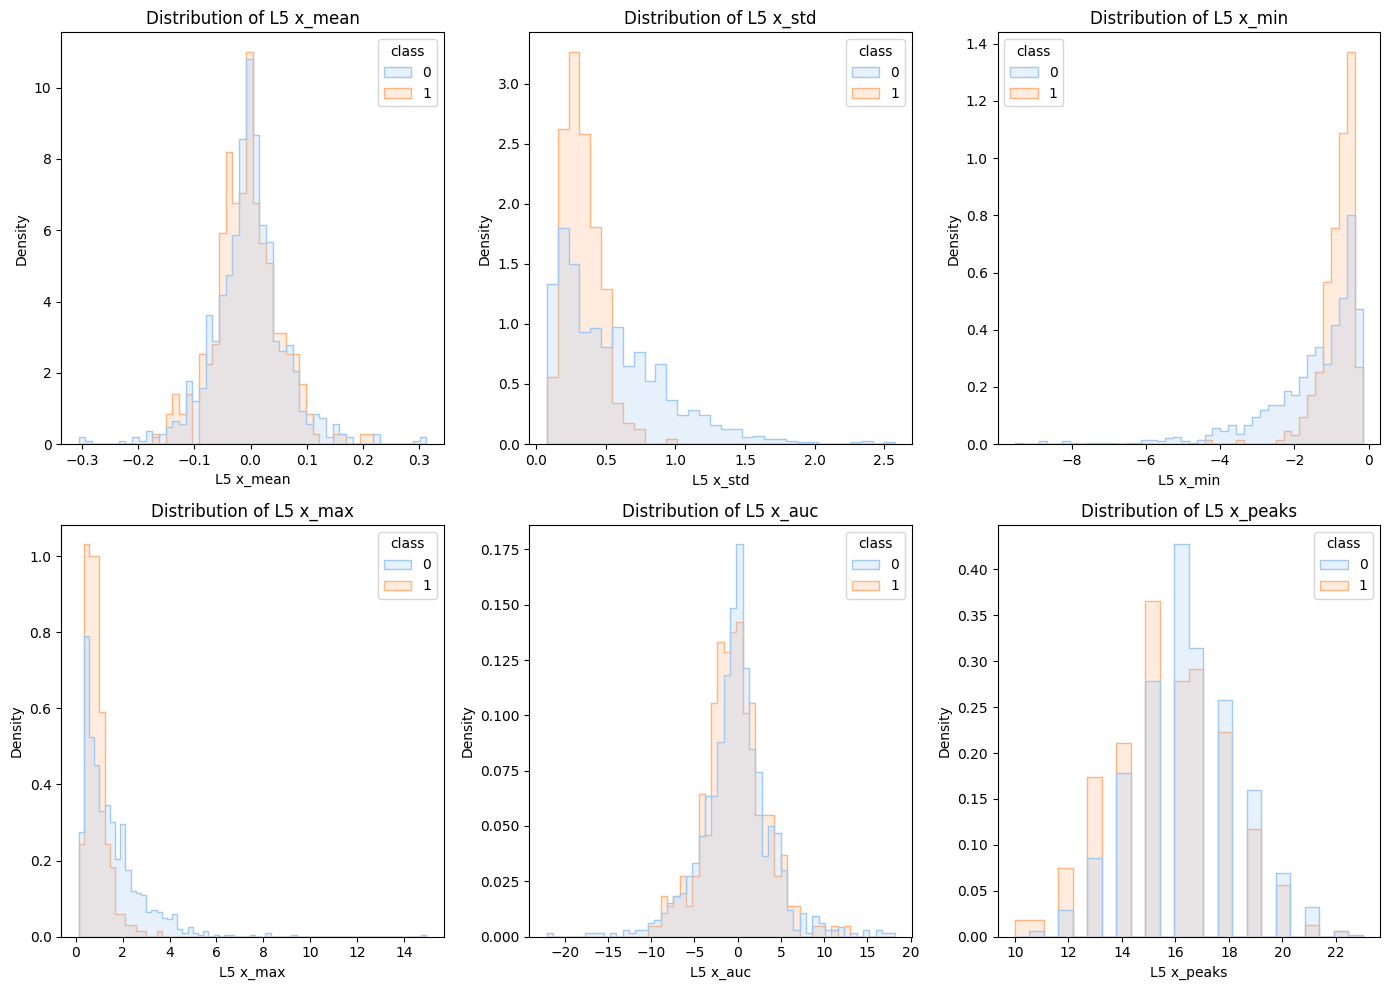

In [43]:
# Select a subset of features to visualize
features_to_plot_grouped = grouped_data.columns[2:8]

plt.figure(figsize=(14, 10))
for i, column in enumerate(features_to_plot_grouped, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=grouped_data, x=column, hue='class', element="step", stat="density", common_norm=False, palette="pastel")
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/3408299641.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=column, data=grouped_data, palette="Set3")
/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/3408299641.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=column, data=grouped_data, palette="Set3")
/var/folders/j4/_l7jsdmj24j2vdmvyd1f9qk80000gn/T/ipykernel_42627/3408299641.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=column, data=grouped_data, palette="Se

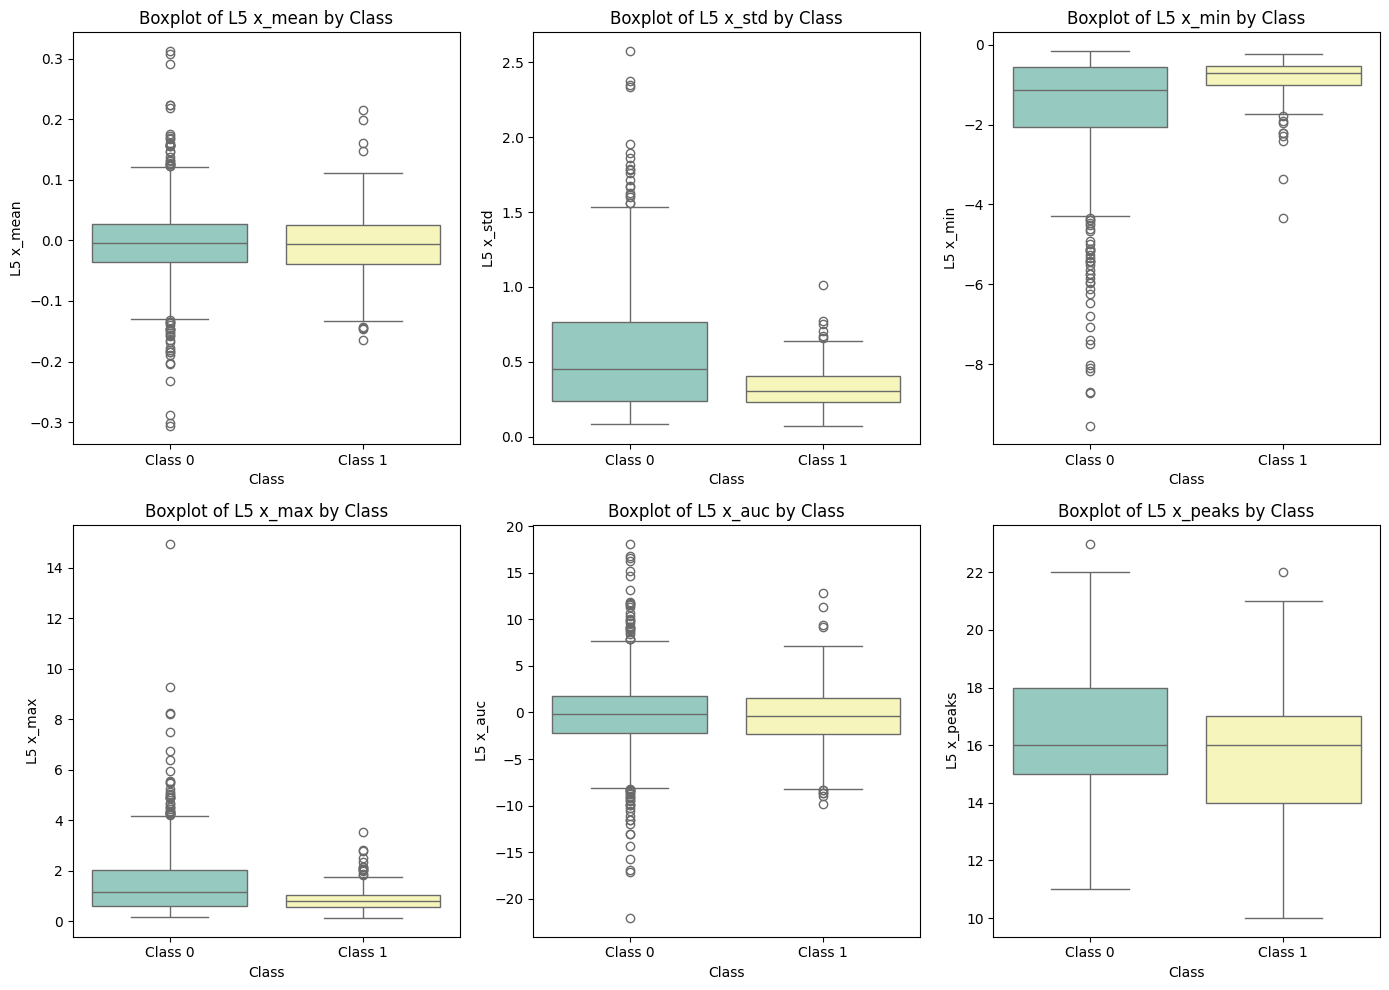

In [44]:
# Plot boxplots of selected grouped features
plt.figure(figsize=(14, 10))
for i, column in enumerate(features_to_plot_grouped, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='class', y=column, data=grouped_data, palette="Set3")
    plt.title(f'Boxplot of {column} by Class')
    plt.xlabel('Class')
    plt.ylabel(column)
    plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])  # Adjust labels if necessary
plt.tight_layout()
plt.show()


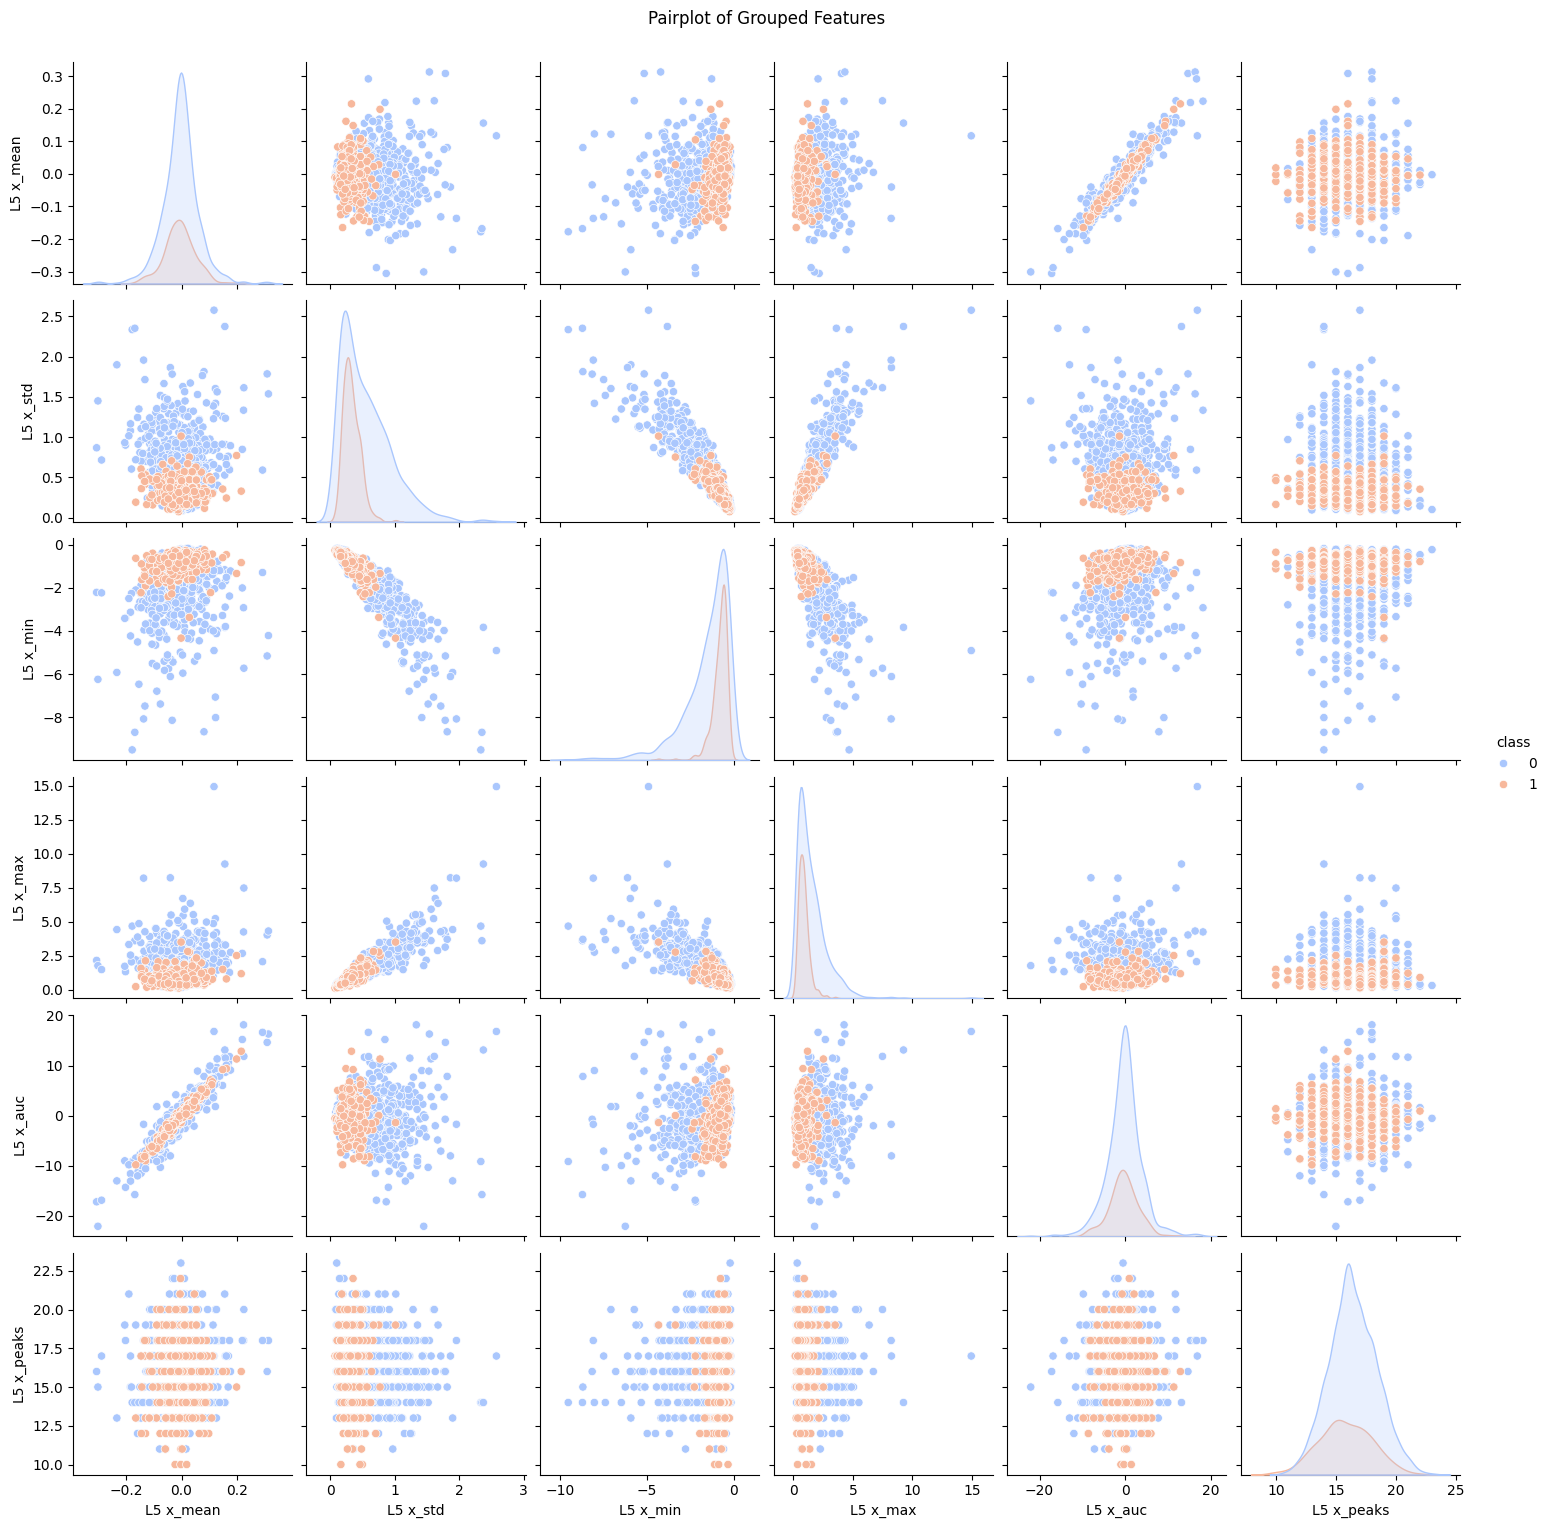

In [45]:
# Pairplot of selected grouped features
sns.pairplot(grouped_data, vars=features_to_plot_grouped, hue='class', palette="coolwarm", diag_kind="kde")
plt.suptitle('Pairplot of Grouped Features', y=1.02)
plt.show()

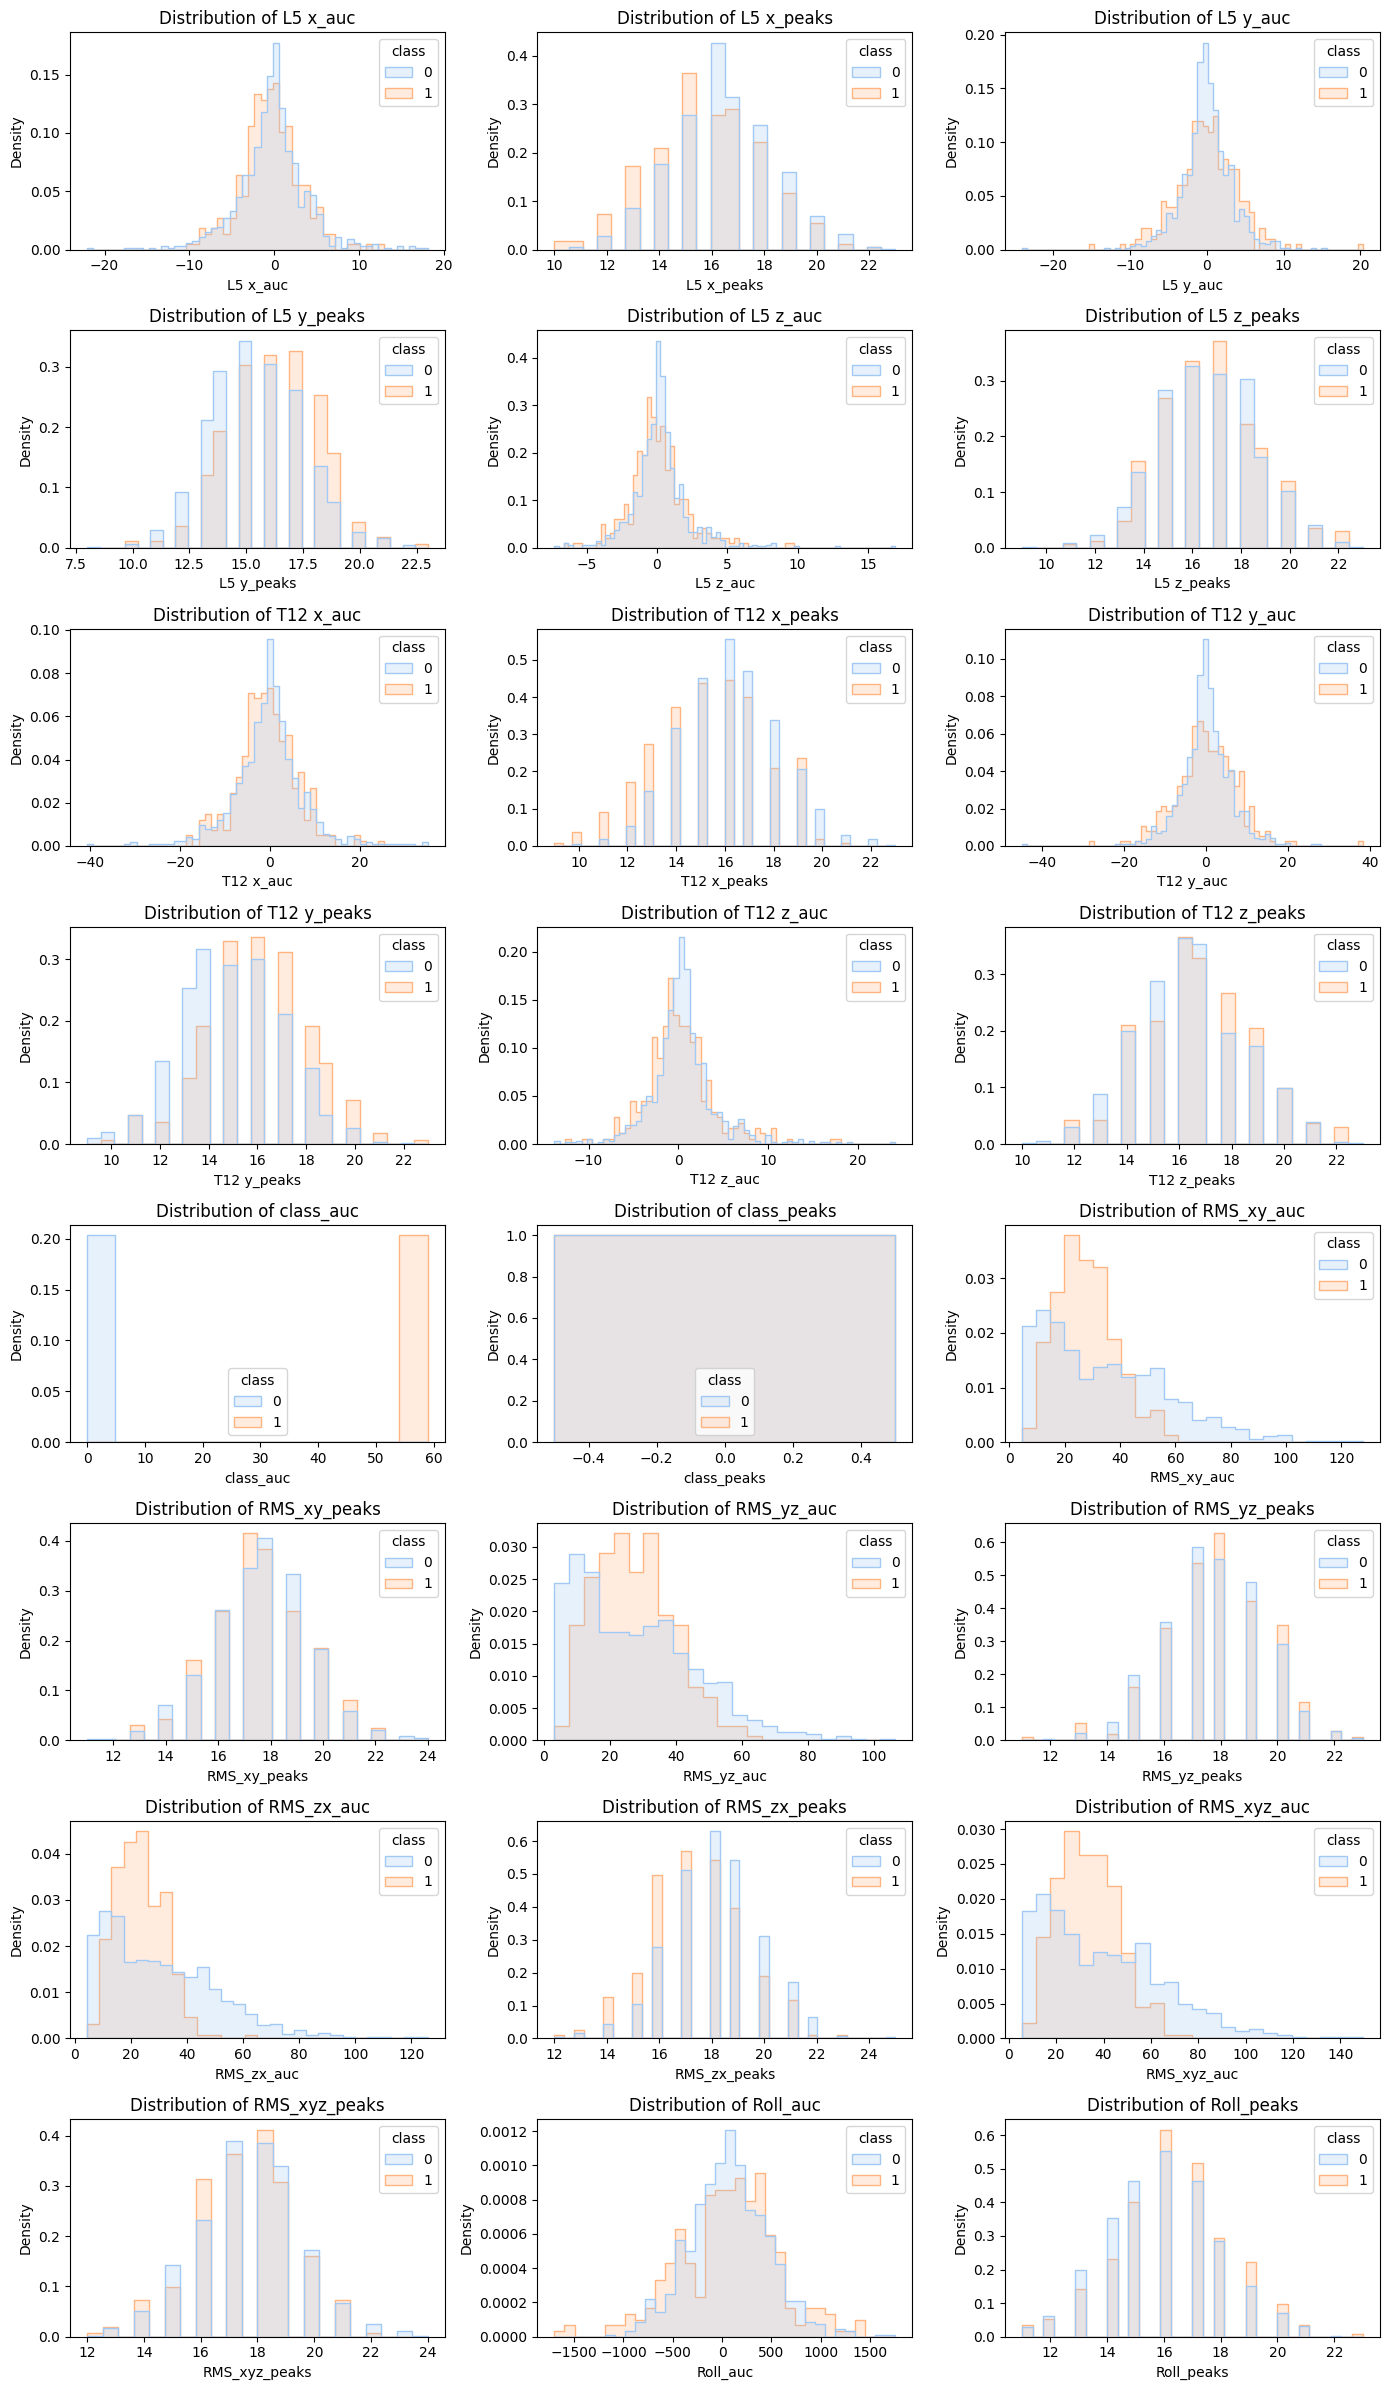

In [46]:
# Analyze Peaks and AUC distributions
features_peaks_auc = [col for col in grouped_data.columns if '_peaks' in col or '_auc' in col]

# Calculate the number of rows and columns needed
num_features = len(features_peaks_auc)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

# Create the plot with dynamic grid size
plt.figure(figsize=(14, num_rows * 3))
for i, column in enumerate(features_peaks_auc, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(data=grouped_data, x=column, hue='class', element="step", stat="density", common_norm=False, palette="pastel")
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()



# Model Training


In [47]:
# Split the data into features (X) and target (y)
X = grouped_data.drop(columns=['class'])
y = grouped_data['class']

# Use stratified splitting to maintain class distribution in train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check the new class distribution
print("Training set class distribution:")
print(y_train.value_counts())

print("\nTesting set class distribution:")
print(y_test.value_counts())


Training set class distribution:
class
0    632
1    208
Name: count, dtype: int64

Testing set class distribution:
class
0    271
1     90
Name: count, dtype: int64


In [48]:
# Training without Hyperparameter Tuning and Cross-Validation
# Train an SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train a SGDClassifier
sgd_model = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_model.fit(X_train, y_train)

# Train a MLPClassifier (Neural Network)
mlp_model = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Evaluate the models using 10-fold cross-validation on the test set
svm_score = cross_val_score(svm_model, X_test, y_test, cv=10).mean()
rf_score = cross_val_score(rf_model, X_test, y_test, cv=10).mean()
sgd_score = cross_val_score(sgd_model, X_test, y_test, cv=10).mean()
mlp_score = cross_val_score(mlp_model, X_test, y_test, cv=10).mean()

# Print the evaluation scores
print(f"SVM Accuracy: {svm_score:.4f}")
print(f"RandomForest Accuracy: {rf_score:.4f}")
print(f"SGDClassifier Accuracy: {sgd_score:.4f}")
print(f"MLPClassifier Accuracy: {mlp_score:.4f}")

SVM Accuracy: 1.0000
RandomForest Accuracy: 1.0000
SGDClassifier Accuracy: 1.0000
MLPClassifier Accuracy: 0.9944


In [49]:
# Training with Hyperparameter Tuning and Cross-Validation
# Hyperparameter Tuning for SVM, RandomForest, SGD, and MLP
# Define parameter grids
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
sgd_param_grid = {'alpha': [0.0001, 0.001, 0.01], 'penalty': ['l2', 'elasticnet']}
mlp_param_grid = {'hidden_layer_sizes': [(50, 50), (100,)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001]}

# Perform GridSearchCV
svm_grid_search = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=10)
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=10)
sgd_grid_search = GridSearchCV(SGDClassifier(random_state=42, max_iter=1000, tol=1e-3), sgd_param_grid, cv=10)
mlp_grid_search = GridSearchCV(MLPClassifier(random_state=42, max_iter=500), mlp_param_grid, cv=10)

# Fit the models
svm_grid_search.fit(X_train, y_train)
rf_grid_search.fit(X_train, y_train)
sgd_grid_search.fit(X_train, y_train)
mlp_grid_search.fit(X_train, y_train)

# Evaluate the best models using cross-validation on the test set
svm_best = svm_grid_search.best_estimator_
rf_best = rf_grid_search.best_estimator_
sgd_best = sgd_grid_search.best_estimator_
mlp_best = mlp_grid_search.best_estimator_

svm_score = cross_val_score(svm_best, X_test, y_test, cv=10).mean()
rf_score = cross_val_score(rf_best, X_test, y_test, cv=10).mean()
sgd_score = cross_val_score(sgd_best, X_test, y_test, cv=10).mean()
mlp_score = cross_val_score(mlp_best, X_test, y_test, cv=10).mean()

# Print the evaluation scores
print(f"SVM Best Model Accuracy: {svm_score:.4f}")
print(f"RandomForest Best Model Accuracy: {rf_score:.4f}")
print(f"SGDClassifier Best Model Accuracy: {sgd_score:.4f}")
print(f"MLPClassifier Best Model Accuracy: {mlp_score:.4f}")


SVM Best Model Accuracy: 1.0000
RandomForest Best Model Accuracy: 1.0000
SGDClassifier Best Model Accuracy: 1.0000
MLPClassifier Best Model Accuracy: 0.9944


In [50]:
# Training with 10 Best Features
# Select the 10 best features
selector = SelectKBest(score_func=f_classif, k=10)
X_train_best = selector.fit_transform(X_train, y_train)
X_test_best = selector.transform(X_test)

# Re-train models with the 10 best features
svm_grid_search.fit(X_train_best, y_train)
rf_grid_search.fit(X_train_best, y_train)
sgd_grid_search.fit(X_train_best, y_train)
mlp_grid_search.fit(X_train_best, y_train)

# Evaluate the best models using cross-validation on the test set with 10 best features
svm_score_best = cross_val_score(svm_grid_search.best_estimator_, X_test_best, y_test, cv=10).mean()
rf_score_best = cross_val_score(rf_grid_search.best_estimator_, X_test_best, y_test, cv=10).mean()
sgd_score_best = cross_val_score(sgd_grid_search.best_estimator_, X_test_best, y_test, cv=10).mean()
mlp_score_best = cross_val_score(mlp_grid_search.best_estimator_, X_test_best, y_test, cv=10).mean()

# Print the evaluation scores
print(f"SVM Accuracy with 10 Best Features: {svm_score_best:.4f}")
print(f"RandomForest Accuracy with 10 Best Features: {rf_score_best:.4f}")
print(f"SGDClassifier Accuracy with 10 Best Features: {sgd_score_best:.4f}")
print(f"MLPClassifier Accuracy with 10 Best Features: {mlp_score_best:.4f}")

/Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [37 38 39 40 41 42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


SVM Accuracy with 10 Best Features: 1.0000
RandomForest Accuracy with 10 Best Features: 1.0000
SGDClassifier Accuracy with 10 Best Features: 1.0000
MLPClassifier Accuracy with 10 Best Features: 1.0000


In [51]:
# Training with 10 Principal Components
# Apply PCA to reduce to 10 principal components
pca = PCA(n_components=10, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Re-train models with 10 principal components
svm_grid_search.fit(X_train_pca, y_train)
rf_grid_search.fit(X_train_pca, y_train)
sgd_grid_search.fit(X_train_pca, y_train)
mlp_grid_search.fit(X_train_pca, y_train)

# Evaluate the best models using cross-validation on the test set with 10 principal components
svm_score_pca = cross_val_score(svm_grid_search.best_estimator_, X_test_pca, y_test, cv=10).mean()
rf_score_pca = cross_val_score(rf_grid_search.best_estimator_, X_test_pca, y_test, cv=10).mean()
sgd_score_pca = cross_val_score(sgd_grid_search.best_estimator_, X_test_pca, y_test, cv=10).mean()
mlp_score_pca = cross_val_score(mlp_grid_search.best_estimator_, X_test_pca, y_test, cv=10).mean()

# Print the evaluation scores
print(f"SVM Accuracy with 10 Principal Components: {svm_score_pca:.4f}")
print(f"RandomForest Accuracy with 10 Principal Components: {rf_score_pca:.4f}")
print(f"SGDClassifier Accuracy with 10 Principal Components: {sgd_score_pca:.4f}")
print(f"MLPClassifier Accuracy with 10 Principal Components: {mlp_score_pca:.4f}")


SVM Accuracy with 10 Principal Components: 1.0000
RandomForest Accuracy with 10 Principal Components: 1.0000
SGDClassifier Accuracy with 10 Principal Components: 1.0000
MLPClassifier Accuracy with 10 Principal Components: 0.9972
